<div style='text-align:center'>
    <h1> ========== COS710 - Assignment 2 ==========</h1>
    <h3>Reuben Jooste - u21457060</h3>
    <hr style='margin:0px 280px;'>
    <h1>=========== Packages ===========</h1>
</div>

In [13]:
# packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from IPython.display import clear_output
import time
import multiprocessing
import sys
from queue import Queue
from tqdm.auto import tqdm
from functools import partial
from multiprocessing import Manager
import os

<div style='text-align:center'><h1>========= Importing Data Files ==========</h1></div>

In [14]:
#load data - source data
source_data_unclean = pd.read_csv('/kaggle/input/diabetes-data-set/diabetes.csv')

#load data - target one data
target_one_data_unclean = pd.read_csv('/kaggle/input/input-data/diabetes_prediction_dataset.csv')

#load data - target two data
target_two_data_unclean = pd.read_csv('/kaggle/input/input-data/Dataset_of_Diabetes.csv')

# remove first two columns of target two since it is only the patient ID and No_Pation
target_two_data_unclean.drop(['ID', 'No_Pation'], axis=1, inplace=True)

# print(source_data_unclean.isin([0]).sum())
# print(target_one_data_unclean.isin([0]).sum())
# print(target_two_data_unclean.isin([0]).sum())

<div style='text-align:center'><h1>========= Analysis on unclean data ==========</h1></div>

In [15]:
def plot_distributions(data, c):
    num_cols = data.select_dtypes(include=[np.number]).columns
    cat_cols = data.select_dtypes(include=[object]).columns

    num_cols_count = len(num_cols)
    cat_cols_count = len(cat_cols)

    total_cols = num_cols_count + cat_cols_count
    num_rows = (total_cols + 1) // 3

    fig, axs = plt.subplots(num_rows, 3, figsize=(12, 3 * num_rows))

    for i, col in enumerate(num_cols):
        if len(data[col]) != 0:
            axs[i // 3, i % 3].hist(data[col], edgecolor='black', alpha=0.7, color=c)
            axs[i // 3, i % 3].set_title(f'Histogram of {col}')
            axs[i // 3, i % 3].set_xlabel(col)
            axs[i // 3, i % 3].set_ylabel('Frequency')

    for i, col in enumerate(cat_cols, start=num_cols_count):
        if len(data[col]) != 0:
            value_counts = data[col].value_counts()
            axs[i // 3, i % 3].bar(value_counts.index, value_counts.values, color=c)
            axs[i // 3, i % 3].set_title(f'Bar chart of {col}')
            axs[i // 3, i % 3].set_xlabel(col)
            axs[i // 3, i % 3].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()
    
def plot_box_plots(data):
    plt.figure(figsize=(15, 8))

    # Exclude the last column
    data_to_plot = data.iloc[:, :-1]  # Exclude the last column

    data_to_plot.boxplot()
    plt.xticks(rotation=45)
    plt.show()

# handle missing values
# we will replace any missing values with the median or mean
# we will also replace any outliers with the median

def clean_data(data, dataset_name):        
    # Replace any outliers
    # Iterate over each column in the DataFrame
    columns = data.columns
    for feature in columns:
        if feature not in ['Outcome', 'diabetes', 'CLASS', 'Gender', 'smoking_history', 'gender', 'hypertension', 'heart_disease']:  # Skip 'Outcome' column if it's not a feature
            # Calculate Q1, Q3, and IQR
            Q1 = data[feature].quantile(0.25)
            Q3 = data[feature].quantile(0.75)
            IQR = Q3 - Q1

            # Define lower and upper bounds
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Identify outliers
            outliers = data[(data[feature] < lower_bound) | (data[feature] > upper_bound)]

            # Replace outliers with the median
            median = data[feature].median()
            data.loc[(data[feature] < lower_bound) | (data[feature] > upper_bound), feature] = median
        elif feature == 'Gender':
            # replace any 'f' with 'F'
            data.loc[data["Gender"] == "f", "Gender"] = 'F'
            
            # now replace the values with 0s and 1s
            data.loc[data["Gender"] == "M", "Gender"] = 1
            data.loc[data["Gender"] == "F", "Gender"] = 0
            
            # change the type of the column
            data['Gender'] = data['Gender'].astype(int)
            
        elif feature == 'gender':
            # drop all rows if gender is 'other'
            indexGender = data[(data['gender'] == 'Other')].index
            data.drop(indexGender, inplace=True)
            
            # now replace the values with 0s and 1s
            data.loc[data["gender"] == "Male", "gender"] = 1
            data.loc[data["gender"] == "Female", "gender"] = 0
            
            # change the type of the column
            data['gender'] = data['gender'].astype(int)
            
        elif feature == 'CLASS':
            # replace any 'Y ' with 'Y' and any 'N ' with 'N'
            data.loc[data["CLASS"] == "Y ", "CLASS"] = 'Y'
            data.loc[data["CLASS"] == "N ", "CLASS"] = 'N'
            
            # remove all rows with 'P' as the CLASS label since the dataset does not include a "BloodSugar" column
            # being classified as 'P' means pre-diabetic with higher blood sugar levels than normal
            # since the dataset does not have a column for this attribute, it would create a bias for our model's prediction when it comes to
            # classifying if the patient is a diabetic or not
            indexClass = data[(data['CLASS'] == 'P')].index
            data.drop(indexClass, inplace=True)            
            
            # replace the Yes values with 1 and the No values with 0
            data.loc[data["CLASS"] == "Y", "CLASS"] = 1
            data.loc[data["CLASS"] == "N", "CLASS"] = 0
            
            # change the type of the column
            data['CLASS'] = data['CLASS'].astype(int)
            
    # Update the names of the features that are in common:
    if dataset_name == 'source':
        data.rename(columns = {'Age':'AGE'}, inplace = True)
        data.rename(columns = {'Glucose':'GLUCOSE'}, inplace = True)
    elif dataset_name == 'target-one':
        data.rename(columns = {'age':'AGE'}, inplace = True)
        data.rename(columns = {'bmi':'BMI'}, inplace = True)
        data.rename(columns = {'blood_glucose_level':'GLUCOSE'}, inplace = True)        
        
    return data 

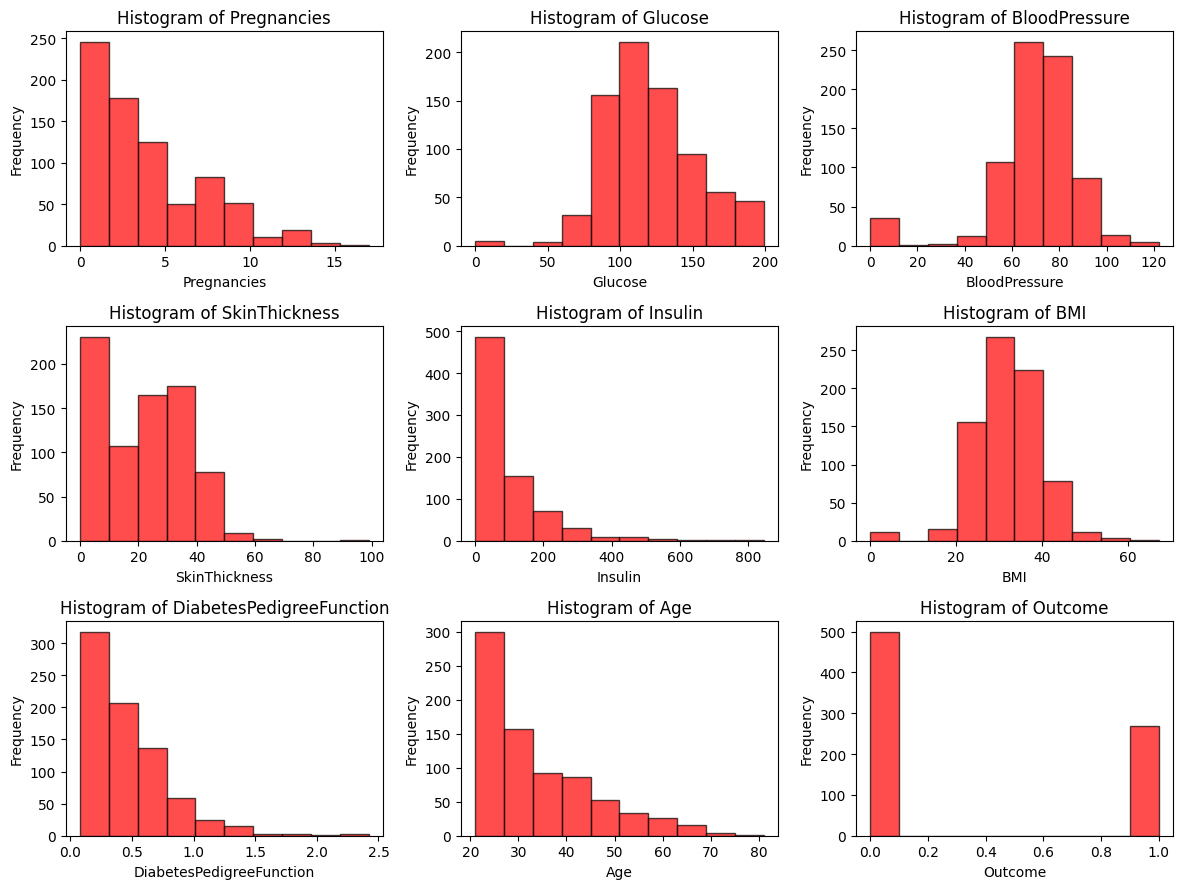

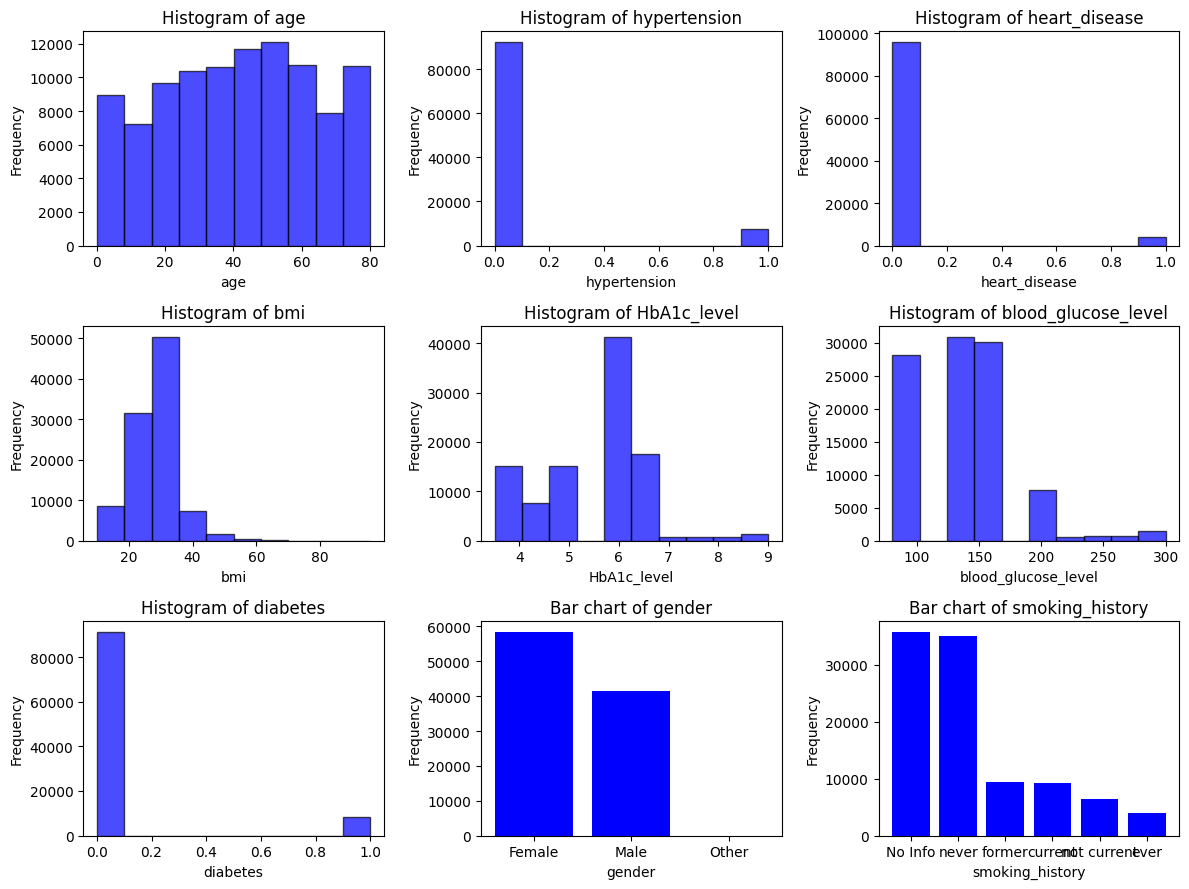

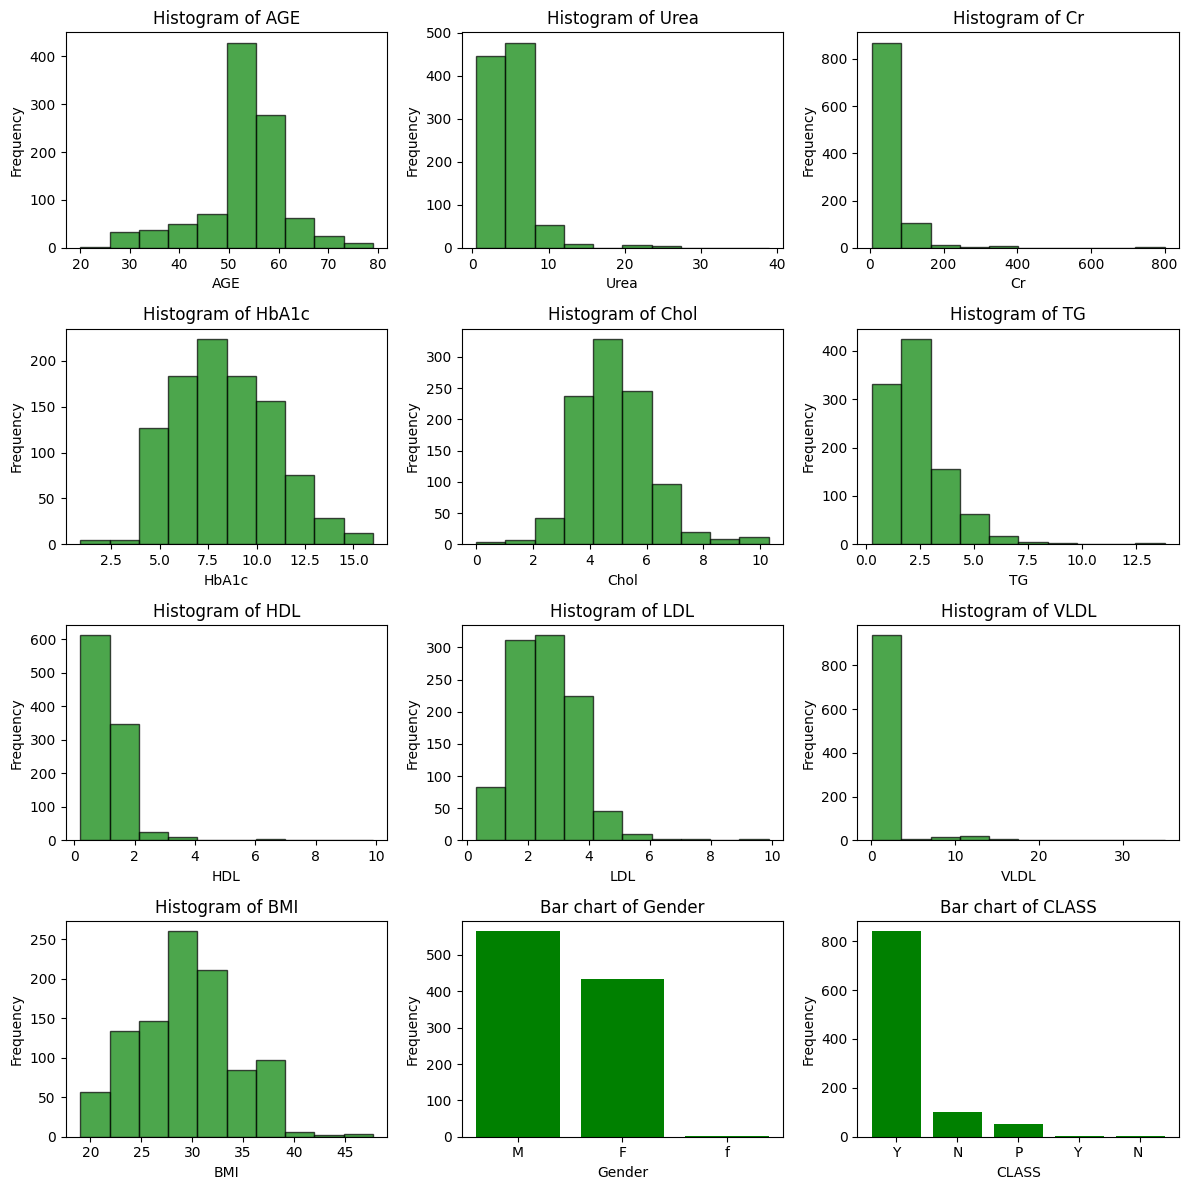

In [16]:
# Analyse unclean data distribution

# plot histograms
plot_distributions(source_data_unclean, 'red') # source

plot_distributions(target_one_data_unclean, 'blue') # target one

plot_distributions(target_two_data_unclean, 'green') # target two

### Source Dataset - We can see the Glucose, Bloodpressure, and BMI feaures have a more normal distribution than the other features. Usually we would replace any missing values with the MEAN but we know the MEAN is sensitive to outliers so we will first need to analyse if there are any outliers.

### Target One Dataset - Similar to the source data we will first need to evaluate if there are any outliers. We also notice that the Gender has very few, almost zero occurences for the "Other" category meaning it will have no affect on the prediction of the model. We will thus remove all occurences of these values.

### Target Two Dataset - We can clearly see that some of the features have outliers so we will first have to process these values similar to how we will handle it in the previous two dataset. We also see that the Gender and CLASS attributes have errors where a False (F) value is indicated with a lowercase 'f' and also for the CLASS attribute it seems there are two different values for "Yes" and "No".

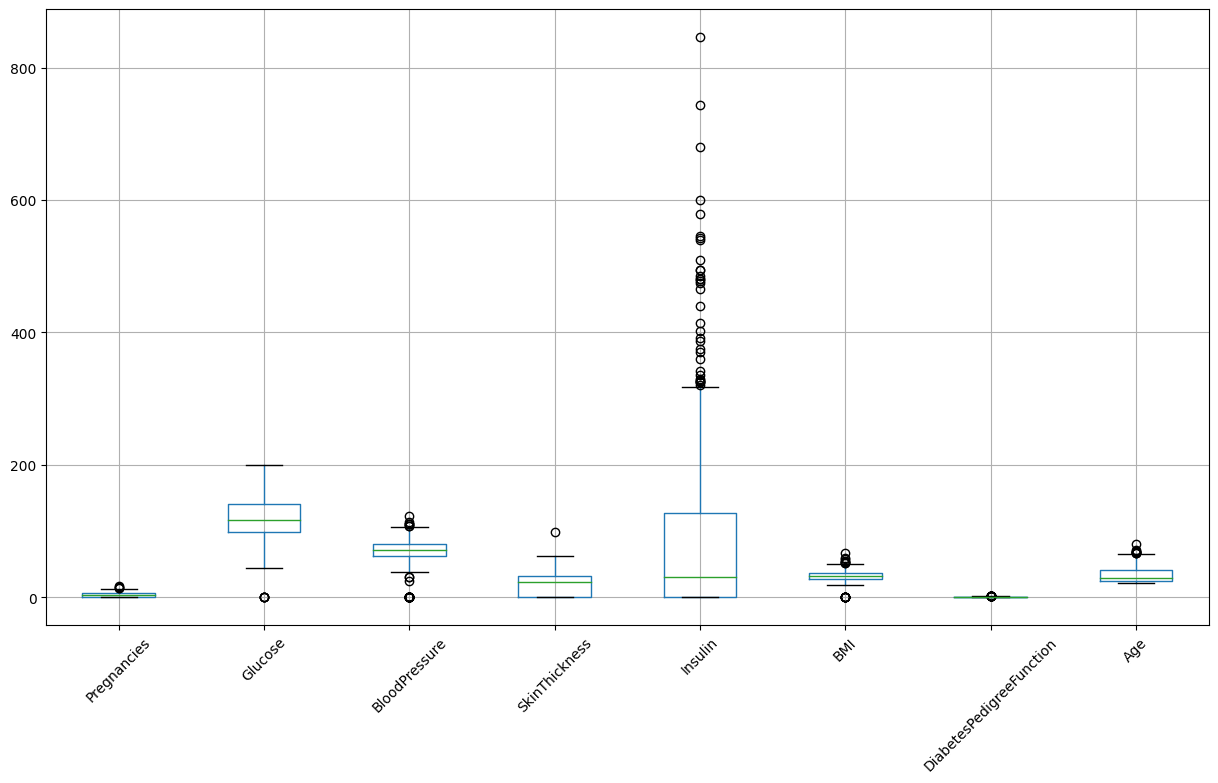

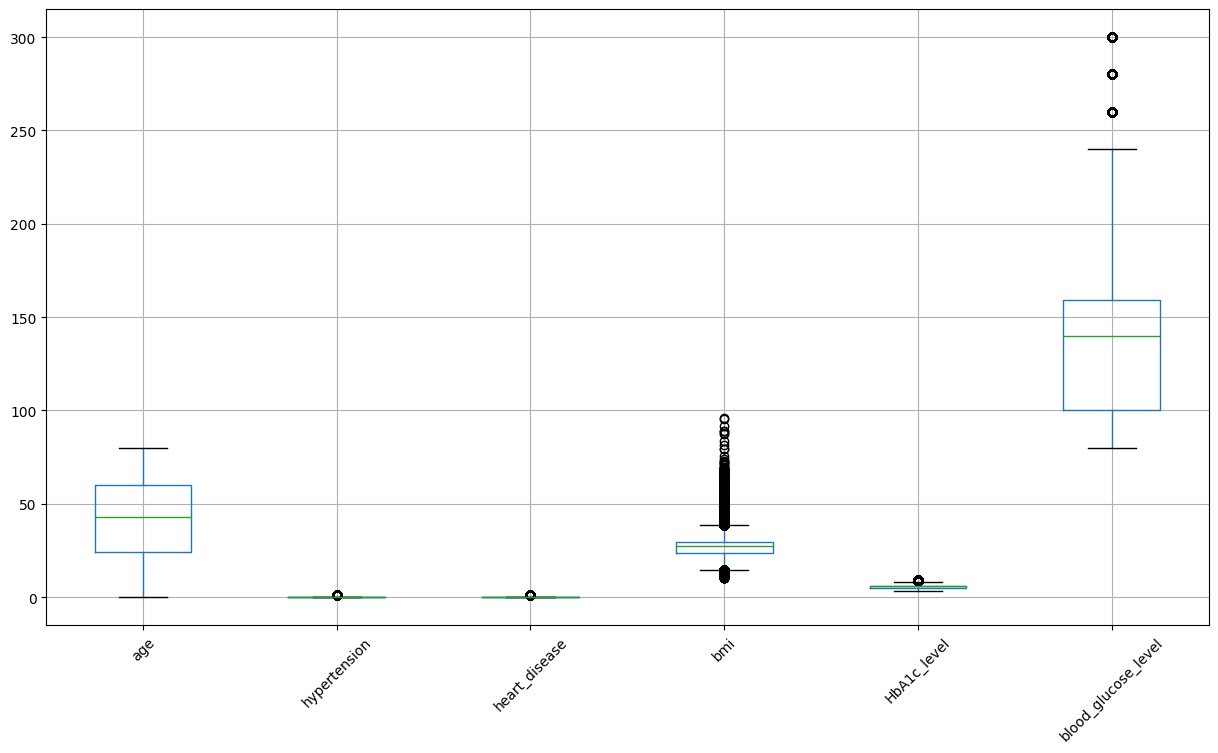

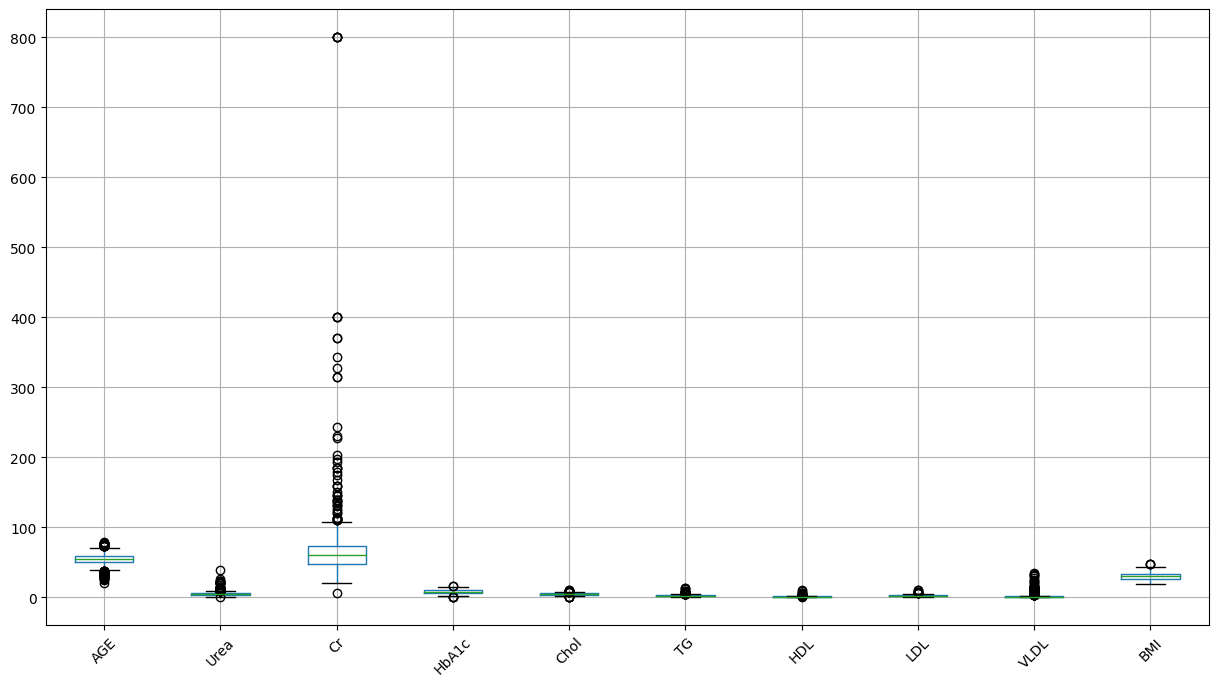

In [17]:
# Create box plots to identify outliers (if any)
plot_box_plots(source_data_unclean)

# Create box plots to identify outliers (if any)
plot_box_plots(target_one_data_unclean)

# Create box plots to identify outliers (if any)
plot_box_plots(target_two_data_unclean)

### We can clearly see that some of the features have outliers. We need to replace these values using the median because the median is less sensitive to outliers compared to the mean. This means that the median still has sort of a central tendency of the data.

## We now look at the cleaned data...

In [18]:
source_data_clean = clean_data(source_data_unclean, 'source')

target_one_data_clean = clean_data(target_one_data_unclean, 'target-one')

target_two_data_clean = clean_data(target_two_data_unclean, 'target-two')

/tmp/ipykernel_64/4253907362.py:65: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '30.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[(data[feature] < lower_bound) | (data[feature] > upper_bound), feature] = median


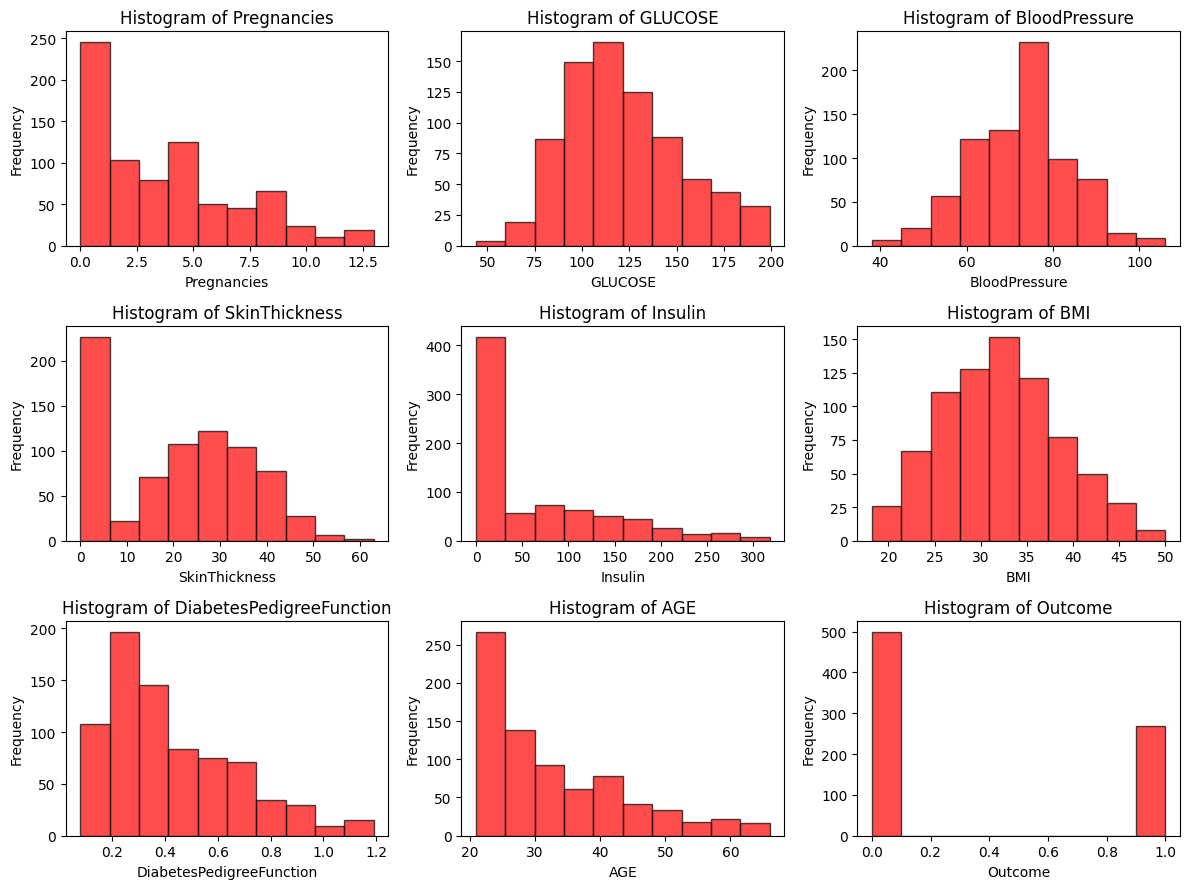

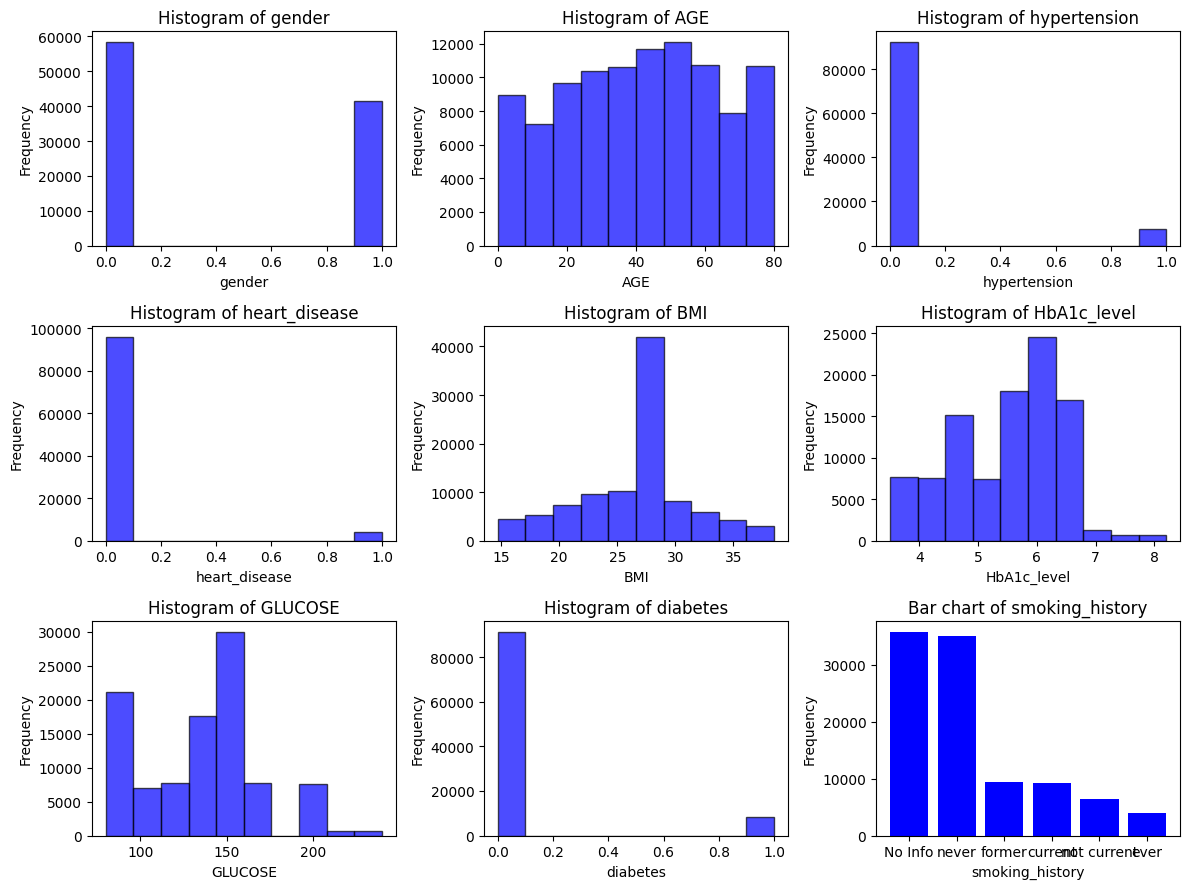

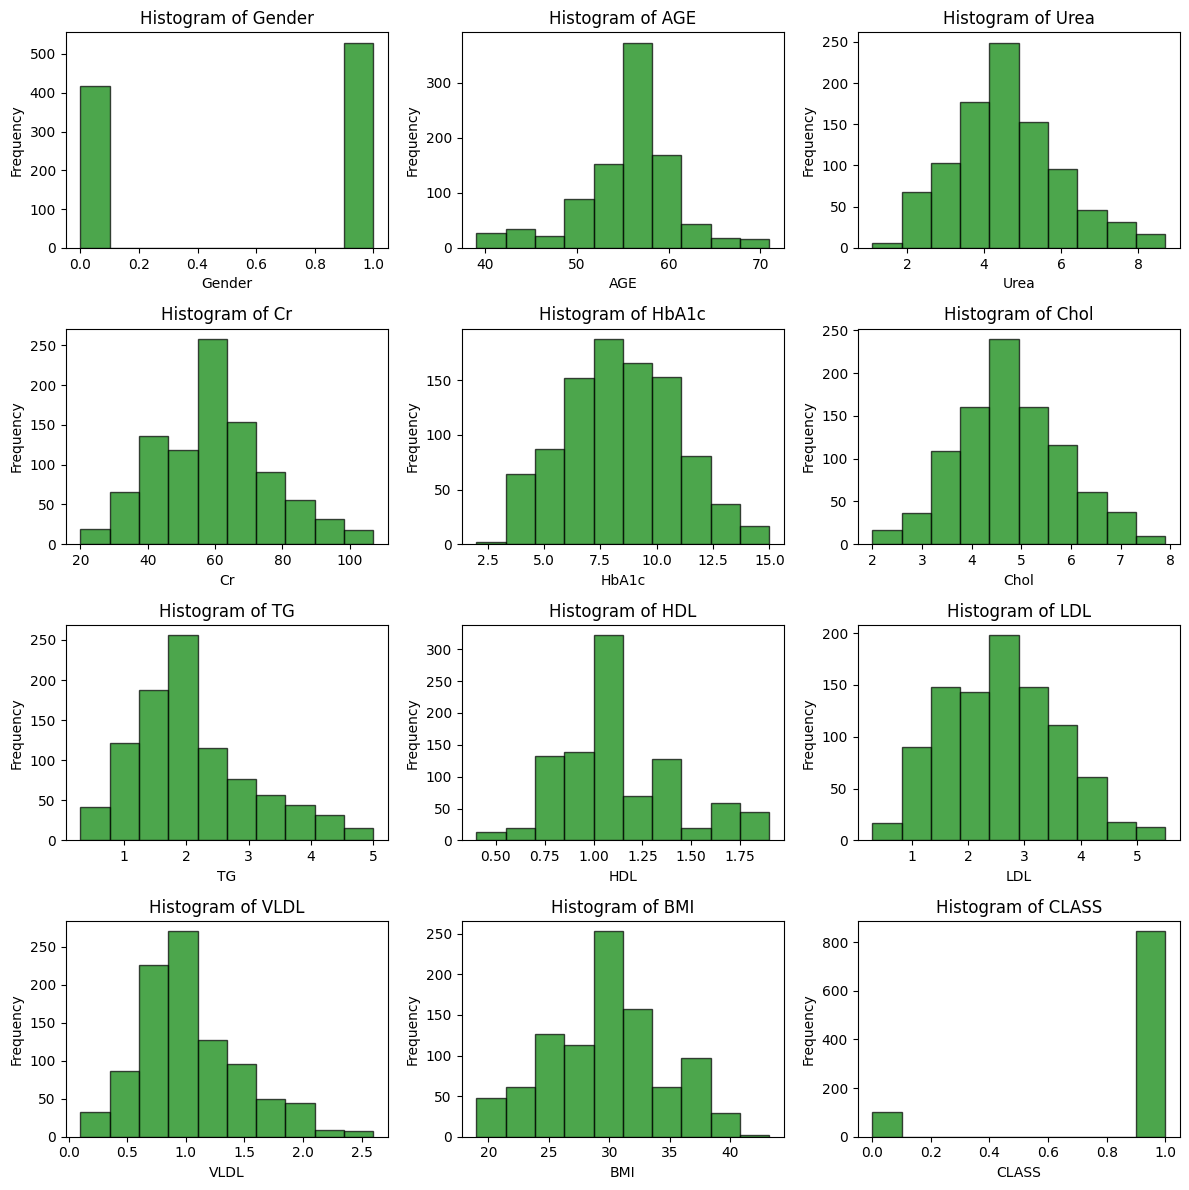

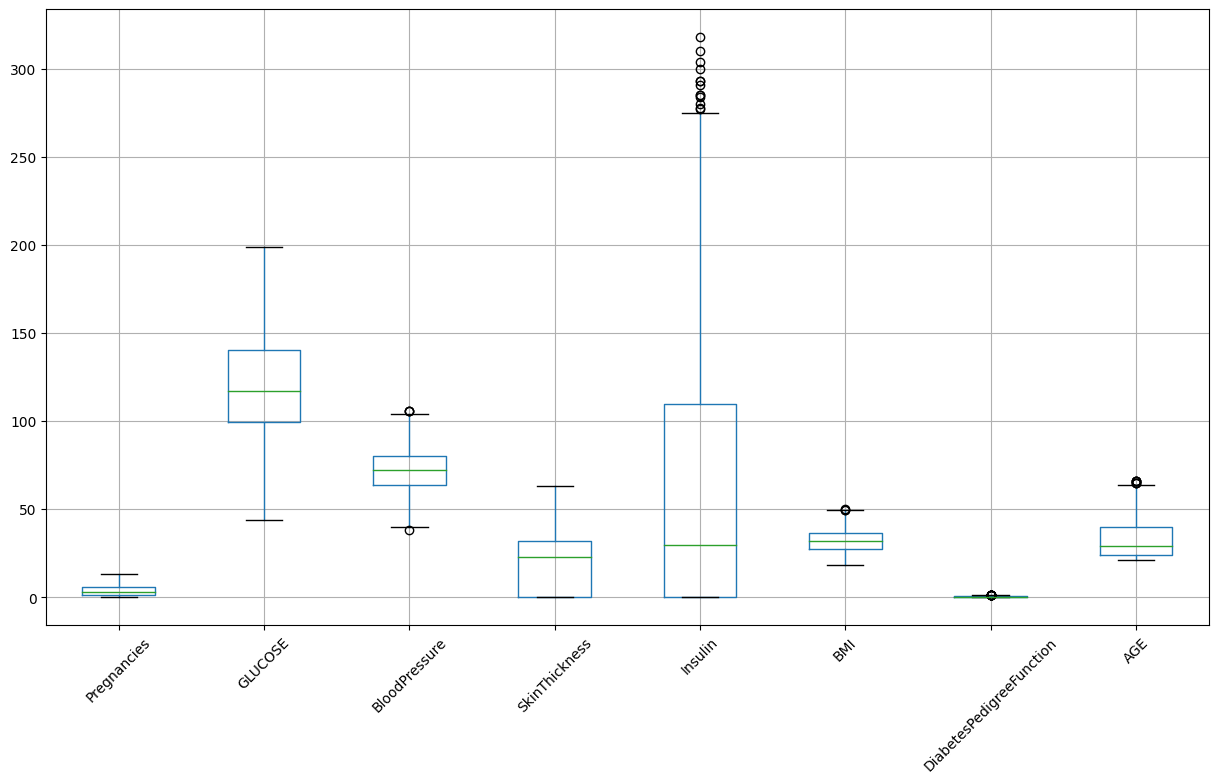

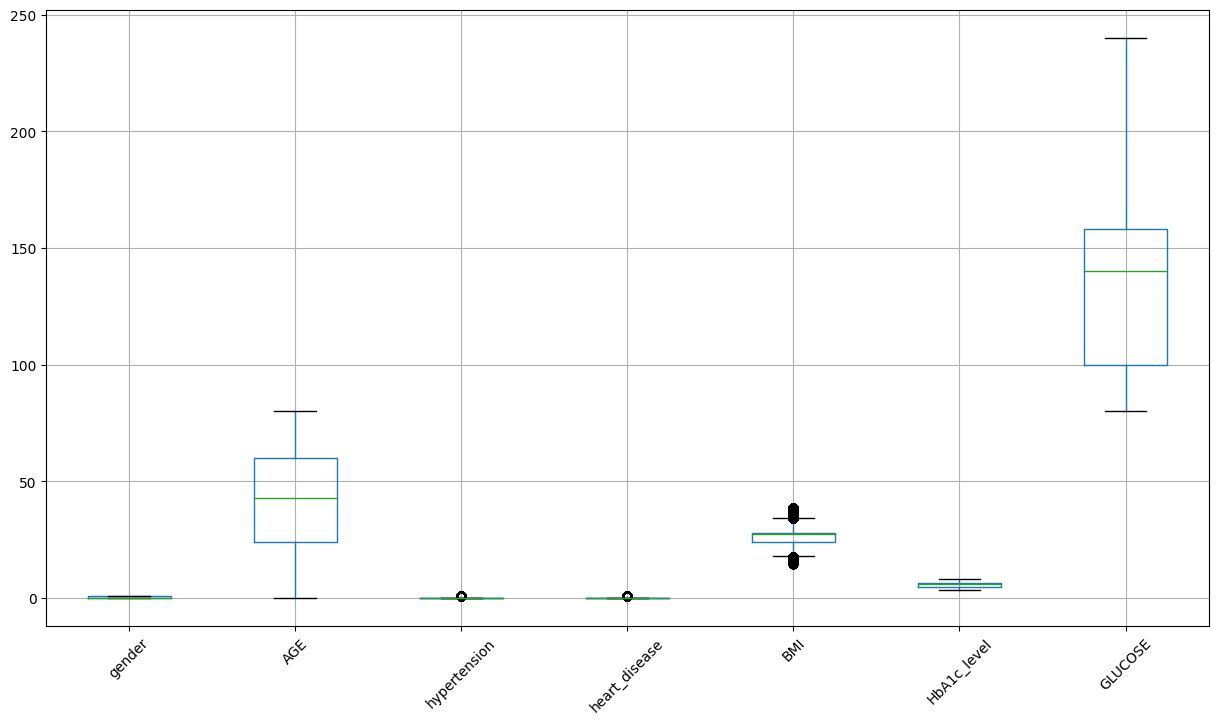

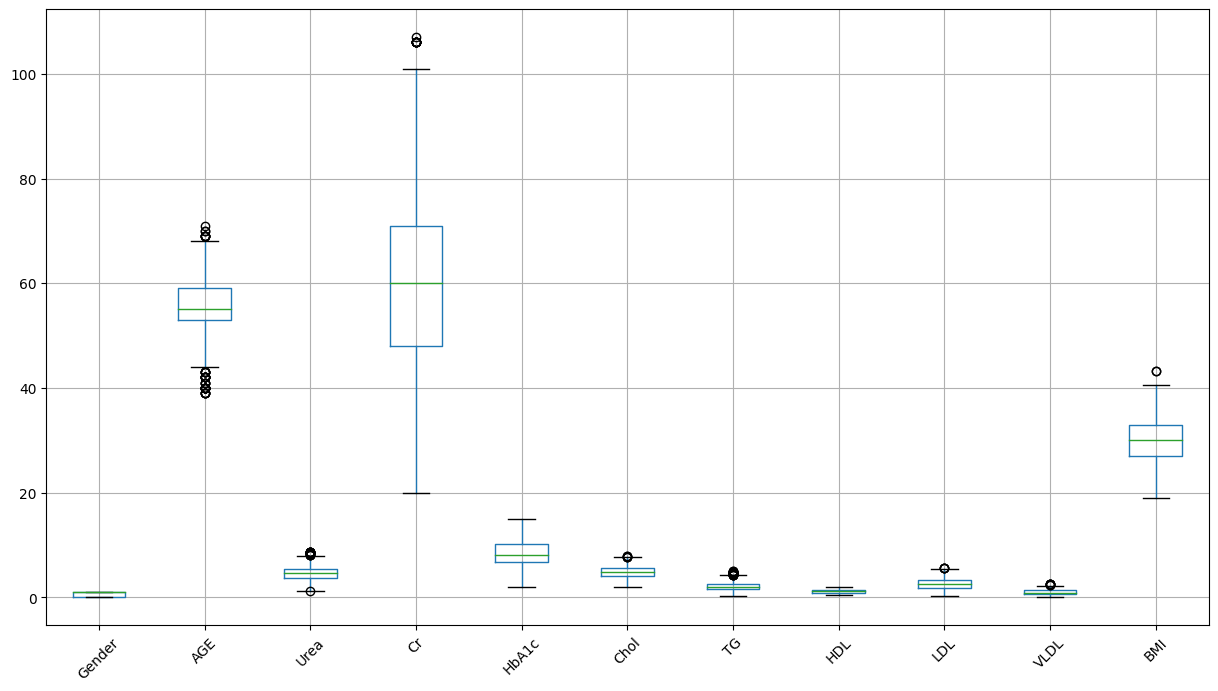

In [19]:
# plot histograms
plot_distributions(source_data_clean, 'red') # source

plot_distributions(target_one_data_clean, 'blue') # target one

plot_distributions(target_two_data_clean, 'green') # target two

plot_box_plots(source_data_clean)

plot_box_plots(target_one_data_clean)

plot_box_plots(target_two_data_clean)

### Now we see that all the data is cleaned and all outliers have been replaced.

# ============= Code needed for main program =============

In [20]:
# Colours Class
class bcolors:
    ANSI_RESET = "\u001B[0m"
    ANSI_RED = "\u001B[31m"
    ANSI_GREEN = "\u001B[32m"
    ANSI_YELLOW = "\u001B[33m"
    ANSI_BLUE = "\u001B[34m"
    ANSI_PURPLE = "\u001B[35m"
    ANSI_CYAN = "\u001B[36m"
    ANSI_WHITE = "\u001B[37m"
    ANSI_BLACK = "\u001B[30m"
    ANSI_BOLD = '\033[1m'
    
# Node Class
class Node:
    def __init__(self, feature, threshold, children, at_depth, data=None, data_labels=None, parent=None, label=None):
        self.feature = feature  # Feature used for splitting (if not a leaf)
        self.threshold = threshold  # Threshold value for split (if not a leaf)
        if children is not None:
            self.children = children.copy() # copy array of children
        else:
            self.children = []
        self.at_depth = at_depth
        self.label = label  # Predicted class label (for leaf nodes)
        self.parent = None # Keep reference of the parent for crossover purposes
        self.data = data
        self.data_labels = data_labels
    
    def get_all_nodes(self):
        nodes = [self]
        
        for child in self.children:
            nodes.extend(child.get_all_nodes())
            
        return nodes
    
    def copy(self):
        copied_children = []
        left_child = None
        right_child = None
        
        for child in self.children:
            copied_child = child.copy()
            copied_children.append(copied_child)
        
        new_node = Node(self.feature, self.threshold, copied_children, self.at_depth, self.data, self.data_labels, None, self.label)
        
        for child in new_node.children:
            child.parent = new_node
            
        return new_node
    
    def replace_subtree(self, current_node, new_subtree):
        for index, child in enumerate(self.children):
            if child == current_node:
                self.children[index] = new_subtree
#         if self.left == current_node:
#             self.left = new_subtree
#         elif self.right == current_node:
#             self.right = new_subtree
        new_subtree.parent = self
        
    def is_leaf(self):
        return self.label != None or len(self.children) == 0

class ProgressBar:
    def __init__(self, total_steps):
        self.total_steps = total_steps
        self.current_step = 0

    def increment(self):
        self.current_step += 1
        # Optionally, print a message here based on progress

    def get_progress(self):
        return self.current_step / self.total_steps

In [21]:
def print_tree(dataframe, node, indent=" ", prefix="|---"):
    if node is None:
        return
    
    if node.label is not None:
        print(f"{indent}{prefix} Leaf: {node.label} -- depth={node.at_depth}")
        return

    # Check if feature is a categorical feature
    categorical_columns = dataframe.select_dtypes(include=[object]).columns
    
    if node.feature in categorical_columns:
        print(f"{indent}{prefix} {node.feature} -- depth={node.at_depth}")
    else:
        print(f"{indent}{prefix} {node.feature} <= {node.threshold} -- depth={node.at_depth}")
    
    new_indent = indent + "  "
    for i, child in enumerate(node.children):
        prefix = "child " + str(i+1) + " ---"
        print_tree(dataframe, child, new_indent, prefix)
    
# def write_tree(node, file, indent=" ", prefix="|---"):
#     if node is None:
#         return
    
#     if node.label is not None:
#         file.write(f"\n{indent}{prefix} Leaf: {node.label}")
#         return

#     file.write(f"\n{indent}{prefix} {node.feature} <= {node.threshold}")
#     new_indent = indent + "  "
#     write_tree(node.left, file, new_indent, "L---")
#     write_tree(node.right, file, new_indent, "R---")
    
# def record_tree(file, f1_score, accuracy, precision, recall, tree, max_depth, population_depth, population_size, generations, tourney_size, mutation_rate, crossover_rate, seed):
#     f = open(file, "a+")
#     f.write("\nSeed=" + str(seed))
#     f.write("\nMaxDepth="  + str(max_depth))
#     f.write("\nPop_depth=" + str(population_depth))
#     f.write("\nPop_size=" + str(population_size))
#     f.write("\nGenerations=" + str(generations))
#     f.write("\nTourney_size=" + str(tourney_size))
#     f.write("\nMutation_rate=" + str(mutation_rate))
#     f.write("\nCrossover_rate=" + str(crossover_rate))
#     f.write("\nF1-score=" + str(f1_score))
#     f.write("\nAccuracy=" + str(accuracy))
#     f.write("\nPrecision=" + str(precision))
#     f.write("\nRecall=" + str(recall))
#     f.write("\nTree=")
#     write_tree(tree, f)
#     f.close()
    
def train_test_split(data, seed, split_ratio=0.8):
    # Shuffle the data randomly
    data = data.sample(frac=1, random_state=seed)
    
    # Calculate the split index based on the split ratio
    split_index = int(len(data) * split_ratio)
    
    # Split the data into training and testing sets
    training_data = data[:split_index]
    testing_data = data[split_index:]
    
    return training_data, testing_data

In [22]:
#     return tree_array
def generate_individual(seed, X_train, features, existing_labels, max_depth, transferred_tree):
    random.seed(seed)
    return generate_random_tree(X_train, X_train.values, features, existing_labels, max_depth, current_depth=0, selected_features=[], transferred_tree=transferred_tree)

def generate_random_tree(dataframe, data, features, existing_labels, population_depth, current_depth=0, selected_features=[], transferred_tree=None):
    # boolean to decide if we are using the transferred node's feature
    using_transferred_node = False
    
    # Check if feature is a categorical feature
    categorical_columns = dataframe.select_dtypes(include=[object]).columns
    
    if transferred_tree is not None and transferred_tree.feature in features:
        using_transferred_node = True
    
    # Check if any feature has values left
    available_features = [feature for feature in features if np.any(data[:, features.index(feature)])]
    if not available_features or current_depth >= population_depth or (current_depth > 2 and random.random() < 0.5):
        label = random.choice([0,1])
        return Node(None, None, [], current_depth, label=label) # we only add a label since it is a leaf node

    # Choose a random feature from available options
    nonselected_features = [f for f in features if f not in selected_features]
    
    feature = None
    if using_transferred_node:
        feature = transferred_tree.feature
    else:
        feature = random.choice(nonselected_features)
    
    if feature in categorical_columns:        
        category_values = dataframe[feature].unique()
        children_nodes = [] # for every category there will be a child node
        #ensure this feature cannot be used on lower subtrees again
        selected_features.append(feature)
            
        for category in category_values:
            # Split data based on every category for the chosen feature
            category_data, category_labels = split_category_data(data, features, existing_labels, feature, category)
            
            child = generate_random_tree(dataframe, category_data, features, category_labels, population_depth, current_depth + 1, selected_features)
            children_nodes.append(child)
        
        if using_transferred_node:
            # update existing node
            transferred_tree.data = data
            transferred_tree.data_labels = existing_labels
            transferred_tree.children = children_nodes
            
            # Set parent links
            for child in transferred_tree.children:
                child.parent = transferred_tree
            
            return transferred_tree
        else:
            # Create a parent node
            node = Node(feature, None, children_nodes, current_depth, data, existing_labels)
        
            # Set parent links
            for child in node.children:
                child.parent = node
            
            return node
    else:
        # Generate a random threshold based on the chosen feature's values
        feature_values = data[:, features.index(feature)]
        threshold = round(random.uniform(np.min(feature_values), np.max(feature_values)),4)

        # Split data based on the chosen feature and threshold
        left_data, right_data, left_labels, right_labels = split_numeric_data(data, features, existing_labels, feature, threshold)

        # Else traverse deeper
        if using_transferred_node:
            # first go left  
            # Recursively generate child nodes
            left_child = generate_random_tree(dataframe, left_data, features, left_labels, population_depth, current_depth + 1, selected_features, transferred_tree.children[0]) # left child

            # Then go right
            right_child = generate_random_tree(dataframe, right_data, features, right_labels, population_depth, current_depth + 1, selected_features, transferred_tree.children[1]) # right child
        
            # update existing node
            transferred_tree.data = data
            transferred_tree.data_labels = existing_labels
            transferred_tree.threshold = threshold
            transferred_tree.children = [left_child, right_child]
            
            # Set parent links
            for child in transferred_tree.children:
                child.parent = transferred_tree
            
            return transferred_tree
        else:
            # first go left  
            # Recursively generate child nodes
            left_child = generate_random_tree(dataframe, left_data, features, left_labels, population_depth, current_depth + 1, selected_features, None) # left child

            # Then go right
            right_child = generate_random_tree(dataframe, right_data, features, right_labels, population_depth, current_depth + 1, selected_features, None) # right child
        
            # Create a parent node
            node = Node(feature, threshold, [left_child, right_child], current_depth, data, existing_labels)
        
            # Set parent links
            for child in node.children:
                child.parent = node
            
            return node


def split_numeric_data(data, features, existing_labels, feature, threshold):
    # Split data into data left and right of the threshold value

    left_index = data[:, features.index(feature)] <= threshold
    right_index = ~left_index

    left_data = data[left_index]
    right_data = data[right_index]

    left_labels = existing_labels[left_index]
    right_labels = existing_labels[right_index]

    return left_data, right_data, left_labels, right_labels

def split_category_data(data, features, existing_labels, feature, category):
    index = data[:, features.index(feature)] == category
    
    extracted_data = data[index]
    extracted_labels = existing_labels[index]
    
    return extracted_data, extracted_labels

<div style='text-align: center'><h1>========= Genetic Programming Functions ==========</h1></div>

In [46]:
#==============================
#======== GP Functions ========
#==============================
def split_data_by_chunks(data, chunk_size):
    # Split the data into chunks of desired size
    chunks = [data[i:i+chunk_size] for i in range(0, len(data), chunk_size)]
    return chunks

def evaluate_individual(node, X_train, Y_train, features, existing_labels):
    # Split data into chunks
    data_size = len(X_train)
    chunk_size = int(data_size * 0.1)
    X_train_chunks = split_data_by_chunks(X_train, chunk_size)
    Y_train_chunks = split_data_by_chunks(Y_train, chunk_size)
    chunk_fitnesses = []
    
    for X_train_chunk, Y_train_chunk in zip(X_train_chunks, Y_train_chunks):
        chunk_fitnesses.append(evaluate_tree(node, X_train_chunk, Y_train_chunk, features, existing_labels, X_train))

    # Accumulate the values
    correct_predictions, TP_total, FP_total, FN_total = 0, 0, 0, 0
    for i in range(len(chunk_fitnesses)):
        correct_predictions += chunk_fitnesses[i][0]
        TP_total += chunk_fitnesses[i][1]
        FP_total += chunk_fitnesses[i][2]
        FN_total += chunk_fitnesses[i][3]
        
    # Calculate accuracy as the fitness score
    accuracy = correct_predictions / data_size
    precision = TP_total / (TP_total + FP_total) if (TP_total + FP_total) > 0 else 0
    recall = TP_total / (TP_total + FN_total) if (TP_total + FN_total) > 0 else 0
    F1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return [F1_score, accuracy, precision, recall]
    
def evaluate_tree(node, X_train, Y_train, features, existing_labels, full_dataframe):    
    correct_predictions = 0
    data_size = len(X_train)
    TP = 0  # True Positives
    FP = 0  # False Positives
    FN = 0  # False Negatives
    # Check if feature is a categorical feature
    categorical_columns = full_dataframe.select_dtypes(include=[object]).columns

    # run through the training data
    for i in range(data_size):
        iterator_node = node.copy()
        instance = X_train.iloc[i, :]
        target_label = Y_train.iloc[i]
    
        while not iterator_node.is_leaf(): 
            if iterator_node.feature in categorical_columns:
                # get index of instance's category
                feature = iterator_node.feature
                feature_values = list(full_dataframe[feature].unique())
                category_index = feature_values.index(instance[feature])
                
                # now follow the index branch
                iterator_node = iterator_node.children[category_index]
            else:                
                if instance.get(iterator_node.feature) <= iterator_node.threshold:
                    iterator_node = iterator_node.children[0]
                else:
                    iterator_node = iterator_node.children[1]
        # get the predicted label
        predicted_label = iterator_node.label
        # Update counters based on prediction
        if predicted_label == target_label:
            correct_predictions += 1
            TP += 1
        else:
            if predicted_label == 1:
                FP += 1
            else:
                FN += 1 

    
    return [correct_predictions, TP, FP, FN]
    
def tournament_select(population, fitness_values, tourney_size):
    pop_size = len(population)
    random_indices = [random.randrange(0, pop_size) for _ in range(tourney_size)]
    curr_best_index = random_indices[0] # randomly select an index
    curr_best_fitness = fitness_values[curr_best_index][0] # select randomly selected fitness value - [0] for F1-score
    
    for i, candidate_index in enumerate(random_indices[:1]):
        candidate_fitness = fitness_values[candidate_index][0]
        
        # test if candidate is new winner
        if candidate_fitness > curr_best_fitness:
            # update best fitness candidate and the index
            curr_best_fitness = candidate_fitness 
            curr_best_index = candidate_index
    return population[curr_best_index]

def update_threshold(node, parent, X_train, labels, features):
    if node is None or node.is_leaf():
        return
    
    if parent is None:
        # Check if feature is a categorical feature
        categorical_columns = X_train.select_dtypes(include=[object]).columns
        
        node.data = X_train
        node.data_labels = labels
        if node.feature not in categorical_columns:
            # Generate a random threshold based on the chosen feature's values
            feature_values = X_train.values[:, features.index(node.feature)]
            threshold = round(random.uniform(np.min(feature_values), np.max(feature_values)), 4)
            node.threshold = threshold
    
    #Else use parent node's data
    else:
        # Check if feature is a categorical feature
        categorical_columns = X_train.select_dtypes(include=[object]).columns
            
        if parent.feature in categorical_columns:
            # determine which branch of the parent the child is
            index = parent.children.index(node)
            category_values = X_train[parent.feature].unique() # categories
            category = category_values[index]

            # Split data based on the chosen feature for the parent
            category_data, category_labels = split_category_data(parent.data, features, parent.data_labels, parent.feature, category)
            
            # if data is empty we create a leaf node
            if len(category_data) == 0:
                label = random.choice([0,1])
                new_node = Node(None, None, [], node.at_depth, label=label)

                node.parent.replace_subtree(node, new_node)
                return
            node.data = category_data
            node.data_labels = category_labels
        
            if node.feature not in categorical_columns:
                # we do need a threshold value for a numerical feature
                feature_values = category_data[:, features.index(node.feature)]
                threshold = round(random.uniform(np.min(feature_values), np.max(feature_values)), 4)
                node.threshold = threshold
                
        else:
            # first get left and right data according to parent's data
            left_data, right_data, left_labels, right_labels = split_numeric_data(parent.data, features, parent.data_labels, parent.feature, parent.threshold)

            # if either side array (left or right) is empty we create a leaf node
            if len(left_data) == 0 or len(right_data) == 0:
                label = random.choice([0,1])
                new_node = Node(None, None, [], node.at_depth, label=label)

                node.parent.replace_subtree(node, new_node)
                return
            # Else
            # test which child the current node is
            if node == parent.children[0]:
                node.data = left_data
                node.data_labels = left_labels
                
                if node.feature not in categorical_columns:
                    # we do need a threshold value for a numerical feature
                    # Generate a random threshold based on the chosen feature's values
                    feature_values = left_data[:, features.index(node.feature)]
                    threshold = round(random.uniform(np.min(feature_values), np.max(feature_values)), 4)
                    node.threshold = threshold
                    
            elif node == parent.children[1]:
                node.data = right_data
                node.data_labels = right_labels
                
                if node.feature not in categorical_columns:
                    # we do need a threshold value for a numerical feature
                    # Generate a random threshold based on the chosen feature's values
                    feature_values = right_data[:, features.index(node.feature)]
                    threshold = round(random.uniform(np.min(feature_values), np.max(feature_values)), 4)
                    node.threshold = threshold

def update_depth(node, parent_depth, max_depth, X_train, labels, features):
    if node is None:
        return
    node.at_depth = parent_depth+1  # Update current node depth
    
    # We need to Prune the subtree if we reached max depth
    if node.at_depth == max_depth:
        # node should be leaf node instead
        label = random.choice([0,1])
        node.parent.replace_subtree(node, Node(None, None, [], max_depth, label=label))
        return
    
    # first update the node's threshold to still make sense according to the tree structure
    update_threshold(node, node.parent, X_train, labels, features)
    
    for child in node.children:
        update_depth(child, node.at_depth, max_depth, X_train, labels, features)  # Update child subtree

def crossover(parent1, parent2, max_depth, X_train, labels, features):    
    p1_copy = parent1.copy()
    p2_copy = parent2.copy()
    
    # create two selection points; one for each parent
    crossover_point1 = random.choice(parent1.get_all_nodes()[1:])
    crossover_point2 = random.choice(parent2.get_all_nodes()[1:])
    
    cp1_copy = crossover_point1.copy()
    
    if crossover_point1.parent is not None:
        node = crossover_point2.copy()
        crossover_point1.parent.replace_subtree(crossover_point1, node)
        update_depth(node, crossover_point1.parent.at_depth, max_depth, X_train, labels, features)
    else:
        crossover_point1 = crossover_point2.copy()
        crossover_point1.parent = None
        update_depth(crossover_point1, -1, max_depth, X_train, labels, features)
    
    if crossover_point2.parent is not None:
#         node = cp1_copy.copy()
        crossover_point2.parent.replace_subtree(crossover_point2, cp1_copy)
        update_depth(cp1_copy, crossover_point2.parent.at_depth, max_depth, X_train, labels, features)
    else:
        crossover_point2 = crossover_point1.copy()
        crossover_point2.parent = None
        update_depth(crossover_point2, -1, max_depth, X_train, labels, features)

    return [p1_copy, p2_copy]

def mutate(tree, mutation_rate, dataframe, features, max_depth, labels):
    mutated_tree = tree.copy()  # Make a copy of the tree to avoid modifying the original
    
    mutation_point = random.choice(mutated_tree.get_all_nodes()[1:])

    if mutation_point.at_depth == max_depth:
        mutation_point.label ^= 1 # Bitwise XOR operation to flip the label
        return mutated_tree
    else:
        # Remove node at mutation point with new subtree or a terminal node
        choice = random.choice([0,1])

        if choice:
            # create new subtree        
            # Choose a random feature from available options
            feature = random.choice(features)
            # Check if feature is a categorical feature
            categorical_columns = dataframe.select_dtypes(include=[object]).columns
            
            if feature in categorical_columns:
                category_values = dataframe[feature].unique()
                children_nodes = [] # for every category there will be a child node

                for category in category_values:
                    label = random.choice([0,1])
                    leaf_node = Node(None, None, [], mutation_point.at_depth+1, label=label)
                    children_nodes.append(leaf_node)

                # Create a parent node
                node = Node(feature, None, children_nodes, mutation_point.at_depth, dataframe.values, labels)
                
                # Set parent links
                for child in node.children:
                    child.parent = node

                if mutation_point.parent is not None:
                    mutation_point.parent.replace_subtree(mutation_point, node)
                else:
                    mutation_point = node   
                
                # update the threshold value and data
                update_threshold(node, mutation_point.parent, dataframe, labels, features)
                
            else:
                # Generate a random threshold based on the chosen feature's values
                if mutation_point.parent is not None and len(mutation_point.parent.data) > 0:
                    feature_values = mutation_point.parent.data[:, features.index(feature)]
                else:
                    feature_values = dataframe.values[:, features.index(feature)]
                threshold = round(random.uniform(np.min(feature_values), np.max(feature_values)), 4)

                # Create child leaf nodes
                label = random.choice([0,1])
                left_child = Node(None, None, [], mutation_point.at_depth+1, label=label)

                label = random.choice([0,1])
                right_child = Node(None, None, [], mutation_point.at_depth+1, label=label)

                # Create a parent node
                node = Node(feature, threshold, [left_child, right_child], mutation_point.at_depth, dataframe.values, labels)

                left_child.parent = node
                right_child.parent = node

                if mutation_point.parent is not None:
                    mutation_point.parent.replace_subtree(mutation_point, node)
                else:
                    mutation_point = node

                # update the threshold value
                update_threshold(node, mutation_point.parent, dataframe, labels, features)
            
        else:
            label = random.choice([0,1])
            node = Node(None, None, [], mutation_point.at_depth, label=label)
            
            if mutation_point.parent is not None:
                mutation_point.parent.replace_subtree(mutation_point, node)
            else:
                mutation_point = node

            mutation_point = node

    return mutated_tree

def build_individual(g, initial_population, fitness_values, tourney_size, crossover_rate, mutation_rate, X_train, existing_labels, features, max_depth):    
    # Select parents
    parent_one = tournament_select(initial_population, fitness_values, tourney_size)
    parent_two = tournament_select(initial_population, fitness_values, tourney_size)

    # Perform crossover or copy parents
    if random.random() < crossover_rate:
        offsprings = crossover(parent_one, parent_two, max_depth, X_train, existing_labels, features)
    else:
        p1_index = initial_population.index(parent_one)
        p2_index = initial_population.index(parent_two)
        offsprings = [parent_one.copy()] if fitness_values[p1_index] > fitness_values[p2_index] else [parent_two.copy()]

    # Apply mutation
    if random.random() < mutation_rate:
        for i, offspring in enumerate(offsprings):
            offsprings[i] = mutate(offspring, mutation_rate, X_train, features, max_depth, existing_labels)

    # Choose best offspring (if applicable)
    if len(offsprings) >= 2:
        offspring_fitness = [evaluate_tree(T, X_train, Y_train, features, existing_labels, X_train)[0] for T in offsprings]
        best_offspring_index = offspring_fitness.index(max(offspring_fitness))
            
        return offsprings[best_offspring_index]
    else:
        return offsprings[0]

def evolve_population(g, s, initial_population, fitness_values, tourney_size, crossover_rate, mutation_rate, X_train, existing_labels, features, max_depth):
    random.seed(s)
    return build_individual(g, initial_population, fitness_values, tourney_size, crossover_rate, mutation_rate, X_train, existing_labels, features, max_depth)
    
def evolve_DT(X_train, Y_train, max_depth, population_depth, population_size, generations, tourney_size, mutation_rate, crossover_rate, seed, source_tree):
    # ensure we are using a fixed global seed
    random.seed(seed)
    cores = os.cpu_count()-1
    
    features = list(X_train.columns[:])
    existing_labels = Y_train.values  
    
    build_start_time = time.time()
    # Create pool of processes
    with multiprocessing.Pool(cores) as pool:
        # Generate initial population in parallel
        seeds = [random.randint(1, population_size+(population_size//2)) for _ in range(population_size)]
        print("Seed values used for initial population:", seeds)
        transferred_tree = None
        if source_tree is not None:
            transferred_tree = source_tree.copy()
            
        args = [(s, X_train, features, existing_labels, population_depth, transferred_tree) for i,s in enumerate(seeds)]
        initial_population = pool.starmap(generate_individual, args)
    pool.join()
    build_end_time = time.time()
    print(f"{bcolors.ANSI_CYAN}Initial population generation elapsed time {build_end_time - build_start_time}{bcolors.ANSI_RESET}")
    fitness_values = [0 for _ in range(population_size)]    
    tree_generations = []
    fitness_generations = []
    last_10_fitness = []
    
    all_gen_avg_f1_score = []
    all_gen_avg_accuracy = []
    all_gen_avg_precision = []
    all_gen_avg_recall = []
    
    best_f1_score = 0
    best_accuracy = 0
    best_precision = 0
    best_recall = 0
    
    all_gen_run_times = []
    
    # iterate for the number of generations and population size
    for g in range(generations):
        bar_length = 20
        # Print generation accuracy
        print(bcolors.ANSI_RESET)
        print(f"{bcolors.ANSI_BOLD}====================================================================================")
        print(f"Generation: {g + 1}")

        # Create pool of processes
        evaluate_time = time.time()
        with multiprocessing.Pool(cores) as pool:
            # Evaluate fitness of each individual in parallel
            args = [(individual, X_train, Y_train, features, existing_labels) for individual in initial_population]
            fitness_values = pool.starmap(evaluate_individual, args)
        pool.join()
       
        evaluated_time = time.time()
        print(f"{bcolors.ANSI_CYAN}Time to evaluate population: {evaluated_time - evaluate_time}{bcolors.ANSI_RESET}")
        
        # Extract results
        f1_scores = [f1score_accuracy[0] for f1score_accuracy in fitness_values]
        accuracy_scores = [f1score_accuracy[1] for f1score_accuracy in fitness_values]
        precision_scores = [f1score_accuracy[2] for f1score_accuracy in fitness_values]
        recall_scores = [f1score_accuracy[3] for f1score_accuracy in fitness_values]
        
        # Store results
        all_gen_avg_f1_score.append(np.mean(f1_scores)) # Average f1-score of each generation will be stored
        all_gen_avg_accuracy.append(np.mean(accuracy_scores)) # Average accuracy of each generation will be stored
        all_gen_avg_precision.append(np.mean(precision_scores)) # Average precision of each generation will be stored
        all_gen_avg_recall.append(np.mean(recall_scores)) # Average recall of each generation will be stored
            
        # Find the best individual
        best_fitness = max(accuracy_scores)
        result_index = accuracy_scores.index(best_fitness)
        best_index = fitness_values.index([f1_scores[result_index], best_fitness, precision_scores[result_index], recall_scores[result_index]])
        best_individual = initial_population[best_index]
        
        print(f"{bcolors.ANSI_BOLD}{bcolors.ANSI_YELLOW}Average Accuracy: {np.mean(accuracy_scores)}") 
        print(f"{bcolors.ANSI_GREEN}Best Accuracy: {best_fitness}{bcolors.ANSI_RESET}")
        print(f"{bcolors.ANSI_GREEN}F-measure: {f1_scores[result_index]}")
        print(f"{bcolors.ANSI_GREEN}Precision: {precision_scores[result_index]}")
        print(f"{bcolors.ANSI_GREEN}Recall: {recall_scores[result_index]}{bcolors.ANSI_RESET}")
#         print(f"Population Accuracies:\n {accuracy_scores}")
        
        last_10_fitness.append(np.mean(accuracy_scores))
        
        tree_generations.append(best_individual)
        fitness_generations.append([f1_scores[result_index], best_fitness, precision_scores[result_index], recall_scores[result_index]])
        
        if len(last_10_fitness) == 10:
            # if the last 10 generations did not increase by at least 5% on average we stop
            biggest_increase = 0
            for i in range(9):
                increase_percentage = round((last_10_fitness[i + 1] - last_10_fitness[i]) / last_10_fitness[i] * 100, 2)
                if increase_percentage > biggest_increase:
                    biggest_increase = increase_percentage

            if biggest_increase < 1:
                # Stop condition
                all_gen_run_times.append(0.0) # indicates the generation did not finish
                print(f"\n{bcolors.ANSI_BOLD}{bcolors.ANSI_RED}Too few increase in accuracy. Stopping condition met{bcolors.ANSI_RESET}") 
                break
                
            # shift array left
            last_10_fitness.pop(0) # remove oldest element
        
        # if we somehow found 100% accuracy, stop the process
        if best_fitness == 1.0:
            all_gen_run_times.append(0.0) # indicates the generation did not finish
            return best_individual 
        
        new_population = [best_individual.copy()]
        completed = 1

        # Run through population and do selection, crossover, and mutation 
        starttime = time.time()
     
        # Create new seed values
        seed_vals = [random.randint(1, population_size+(population_size//2)) for _ in range(population_size)]
        
        with multiprocessing.Pool(cores) as pool:
            # Prepare arguments for each individual
            args = [(g, s, initial_population, fitness_values, tourney_size, crossover_rate, mutation_rate, X_train, existing_labels, features, max_depth) for s in seed_vals]
            evolved_pop = pool.starmap(evolve_population, args)

        pool.join() # Wait for processes to finish
        
        endtime = time.time()
        new_population.extend(evolved_pop) 
        
        # Store run time of generation
        all_gen_run_times.append(endtime-starttime)
        
        print(f"\n{bcolors.ANSI_BOLD}Elapsed: {bcolors.ANSI_PURPLE}{endtime-starttime}") # print new line
        print(bcolors.ANSI_RESET + bcolors.ANSI_BOLD + "====================================================================================" + bcolors.ANSI_RESET)
        
        # Update population
        initial_population = new_population
        
    # print the best generation tree to a file if it did well enough
    gen_f1_scores = [results[0] for results in fitness_generations]
    gen_accuracy_scores = [results[1] for results in fitness_generations]
    gen_precision_scores = [results[2] for results in fitness_generations]
    gen_recall_scores = [results[3] for results in fitness_generations]
    
    best_gen_fitness = max(gen_accuracy_scores)
    result_index = gen_accuracy_scores.index(best_gen_fitness)
    best_gen_index = fitness_generations.index([gen_f1_scores[result_index], best_gen_fitness, gen_precision_scores[result_index], gen_recall_scores[result_index]])
    best_tree = tree_generations[best_gen_index]
    
    best_results = [gen_f1_scores[result_index], best_gen_fitness, gen_precision_scores[result_index], gen_recall_scores[result_index]]
    generation_results_averages = [all_gen_avg_f1_score, all_gen_avg_accuracy, all_gen_avg_precision, all_gen_avg_recall]
    
#     if gen_accuracy_scores[result_index] > 0.85:
#         file = "generation_records.txt"
#         record_tree(file, gen_f1_scores[result_index], best_gen_fitness, gen_precision_scores[result_index], gen_recall_scores[result_index], best_tree, max_depth, population_depth, population_size, generations, tourney_size, mutation_rate, crossover_rate, seed)
    return best_tree, best_results, generation_results_averages, all_gen_run_times

<div style='text-align:center'><h1>========= Main Program ==========</h1></div>

In [48]:
##### ===========================================
# ============ main program =================
# ===========================================
# Define functions for highlighting
def highlight_max(s):
    """Highlight the maximum value in a Series."""
    is_max = (s == s.max())
    return ['background: lightgreen' if v else '' for v in is_max]

def highlight_min(s):
    """Highlight the minimum value in a Series."""
    is_min = (s == s.min())
    return ['background-color: red' if v else '' for v in is_min]

def highlight_max_runtime(s):
    """Highlight the maximum value in the "Run Time" column."""
    is_max = (s == s.max())
    return ['background-color: red' if v else '' for v in is_max]

def highlight_min_runtime(s):
    """Highlight the minimum value in the "Run Time" column."""
    is_min = (s == s.min()) & (s != 0.0)
    return ['background: lightgreen' if v else '' for v in is_min]

def print_to_file(filename, seed_value, best_results, average_results):        
    f = open(filename, 'a')
    # round all values to 2 decimals
    my_results = [round(value*100,2) for value in best_results]
    
    # convert to str
    str_seed = str(seed_value)
    str_best_f1 = str(my_results[0])
    str_best_accuracy = str(my_results[1])
    str_best_precision = str(my_results[2])
    str_best_recall = str(my_results[3])
    
    if len(average_results) > 0:
        my_avg_results = [round(np.mean(values)*100,2) for values in average_results]
    
        str_avg_f1 = str(my_avg_results[0])
        str_avg_accuracy = str(my_avg_results[1])
        str_avg_precision = str(my_avg_results[2])
        str_avg_recall = str(my_avg_results[3])
    
        # write to file
        f.write(str_seed + ',' + str_best_f1 + ',' + str_best_accuracy + ',' + str_best_precision + ',' + str_best_recall + ',' + str_avg_f1 + ',' + str_avg_accuracy + ',' + str_avg_precision + ',' + str_avg_recall + '\n')
        f.close()
    else:
        # write to file
        f.write(str_seed + ',' + str_best_f1 + ',' + str_best_accuracy + ',' + str_best_precision + ',' + str_best_recall + '\n')
        f.close()
        
def plot_lineplots(data_with_learning, data_without_learning, ylabel, name):
    x_labels = []
    if len(data_with_learning) >= len(data_without_learning):
        x_labels = [i+1 for i in range(len(data_with_learning))]
    else:        
        x_labels = [i+1 for i in range(len(data_without_learning))]
        
    plt.plot(x_labels, data_with_learning, label = "With TL", linestyle="-.", color='red')
    plt.plot(x_labels, data_without_learning, label = "Without TL", linestyle="-.", color='blue') 
    plt.ylabel(ylabel) 
    plt.title(name + " comparison between Source and Target GPs") 
    plt.legend() 
    plt.show()
    
def plot_barplot(x_labels, data, ylabel, name):        
    plt.bar(x_labels, data, width=0.2)
    for i in range(len(x_labels)):
        plt.text(i, data[i], data[i], ha = 'center')
    plt.xlabel("Seed Values for each run") 
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.title(name + " comparison for different seed values (runs)") 
    plt.show()

# Store results with and without transfer learning applied
source_data_results = {'without_learning': [], 'with_learning': []} # arrays are in the format: [tree, best_gen_results, gen_averages, gen_runtimes, transferred_tree]
target_one_data_results = {'without_learning': [], 'with_learning': []}
target_two_data_results = {'without_learning': [], 'with_learning': []}

while True:
    print("Datasets:\nSource Data: diabetes.csv\nTarget One Data: diabetes_prediction_dataset.csv\nTaret Two Data: Datset_of_Diabetes.csv\n")
    input_str = "\nSelect an option:\n1) Train Decision Tree\n2) Test Decision Tree\n3) Compare Source and Target GPs\n4) Compare different runs\n5) Quit Program"
    user_input = input(input_str)
    
    if user_input == "5":
        break
        
    dataset_select_input = input("\nSelect a dataset:\n1) Source dataset\n2) Target One dataset\n3) Target Two dataset\n 4) Quit Program")
    
    if dataset_select_input == "4":
        break
        
    dataset_chosen = ""
    data_clean = None
    if dataset_select_input == "1":
        dataset_chosen = "source data"
        data_clean = source_data_clean
    elif dataset_select_input == "2":
        dataset_chosen = "target one data"
        data_clean = target_one_data_clean[:1000] # Take a sample
    else:
        dataset_chosen = "target two data"
        data_clean = target_two_data_clean
        
#     seed = input('\nEnter seed value: ')
    seeds = [random.randrange(0, 1000000) for _ in range(10)]
#     while True:
#         if seed.isnumeric() == True:
#             seed = int(seed)
#             break
#         print('Invalid seed. Select a valid seed.')
    for seed in seeds:
        random.seed(seed)

        # Split data into training and testing
        training_data, testing_data = train_test_split(data_clean, seed, split_ratio=0.75)

        X_train = training_data.iloc[:,:-1]
        Y_train = training_data.iloc[:,-1]

        X_test = testing_data.iloc[:, :-1]
        Y_test = testing_data.iloc[:,-1]

        if user_input in "1": # Training
            file_name = ""
            print("Input the values for the GP parameters...")
#             max_depth = int(input("Max depth: "))
#             population_depth = int(input("Population depth: "))
#             population_size = int(input("Population size: "))
#             generations = int(input("Generations: "))
#             tourney_size = int(input("Tournament size: "))
#             mutation_rate = float(input("Mutation rate: "))
#             crossover_rate = float(input("Crossover rate: "))
            if dataset_select_input == "1":                
            # ======== Source Data values used =========
                max_depth = 6
                population_depth = 4
                population_size = 150
                generations = 35
                tourney_size = 5
                mutation_rate = 0.15
                crossover_rate = 0.9
            elif data_selection_input == "2":
            # ========== Target One data used ===========
                max_depth = 5
                population_depth = 4
                population_size = 175
                generations = 40
                tourney_size = 7
                mutation_rate = 0.1
                crossover_rate = 0.87
            elif data_selection_input == "3":
            # ========== Target One data used ===========
                max_depth = 5
                population_depth = 4
                population_size = 120
                generations = 42
                tourney_size = 6
                mutation_rate = 0.185
                crossover_rate = 0.83
                

            learning_selection_input = "4"
            if dataset_select_input != "1":
                learning_selection_input = input("\nSelect an option:\n1) Train with Transfer Learning\n2) Train without Transfer Learning\n3) Quit Program")

            if learning_selection_input == "3":
                break        
            elif learning_selection_input == "1":            
                if len(source_data_results["without_learning"]) == 0:
                    print("Unable to do Transfer Learning. Source Dataset must with be trained to produce a Decision Tree.")
                    continue
                else:
                    source_tree = source_data_results["without_learning"][0]
            else:
                source_tree = None

            # Test if we need to do transfer learning or not
            starttime = time.time()
            tree, best_gen_results, gen_averages, gen_run_times = evolve_DT(X_train, Y_train, max_depth, population_depth, population_size, generations, tourney_size, mutation_rate, crossover_rate, seed, source_tree)
            endtime = time.time()
            print("Elapsed Generations: ", endtime-starttime)

            # update the respective data's transferred trees
            if dataset_select_input == "1":
                # source data was chosen
                source_data_results["without_learning"] = [tree, best_gen_results, gen_averages, gen_run_times]
                file_name = "source_seed_results_training.txt"
            elif dataset_select_input == "2":
                # target one data was chosen
                if learning_selection_input == "1":
                    file_name = "target1_seed_results_training_learning.txt"
                    target_one_data_results["with_learning"] = [tree, best_gen_results, gen_averages, gen_run_times]
                else:
                    file_name = "target1_seed_results_training.txt"
                    target_one_data_results["without_learning"] = [tree, best_gen_results, gen_averages, gen_run_times]
            else:
                # target two data was chosen
                if learning_selection_input == "1":
                    file_name = "target2_seed_results_training_learning.txt"
                    target_two_data_results["with_learning"] = [tree, best_gen_results, gen_averages, gen_run_times]
                else:
                    file_name = "target2_seed_results_training.txt"
                    target_two_data_results["without_learning"] = [tree, best_gen_results, gen_averages, gen_run_times]

            # plot all the best results for my algorithm and Papers 1,2, and 3:
            my_results = [round(value*100,2) for value in best_gen_results]
            rounded_run_times = [round(t, 4) for t in gen_run_times]

            x_labels = ['F-measure', 'Accuracy', 'Precision', 'Recall']

            X_axis = np.arange(len(x_labels))

            bar_width = 0.2
            plt.bar(x_labels, my_results, width=bar_width, color="maroon")

            for i in range(len(x_labels)):
                plt.text(i, my_results[i], my_results[i], ha = 'center')

            plt.xticks(X_axis, x_labels) 
            plt.xlabel("Performance metrics") 
            plt.ylabel("Performance Values (%)") 
            plt.title("Performance of best generated Decision Tree (Training)") 
            plt.show()

            # print the seed, best values, average values to a file
            print_to_file(file_name, seed, best_gen_results, gen_averages)

    if user_input == "2":
        print('Testing tree...')
        file_name = ""
        
        learning_selection_input = "4"
        if dataset_select_input != "1":
            learning_selection_input = input("\nSelect an option:\n1) Test with Transfer Learning\n2) Test without Transfer Learning\n3) Quit Program")
        
        trained_tree = None
        if dataset_select_input == "1":
            # source data was chosen
            trained_tree = source_data_results["without_learning"][0]
            file_name = "source_seed_results_testing.txt"
        elif dataset_select_input == "2":
            # target one data was chosen
            if learning_selection_input == "1":
                file_name = "target1_seed_results_testing_learning.txt"
                trained_tree = target_one_data_results["with_learning"][0]
            else:
                file_name = "target1_seed_results_testing.txt"
                trained_tree = target_one_data_results["without_learning"][0]
        else:
            # target two data was chosen
            if learning_selection_input == "1":
                file_name = "target2_seed_results_testing_learning.txt"
                trained_tree = target_two_data_results["with_learning"][0]
            else:
                file_name = "target2_seed_results_testing.txt"
                trained_tree = target_two_data_results["without_learning"][0]
        
        if trained_tree == None:
            print("No trained tree found!")
            continue
            
        features = list(X_train.columns[:])
        existing_labels = Y_train.values
        fitnesses = evaluate_tree(trained_tree, X_test, Y_test, features, existing_labels, X_test)
        my_results = [round(value*100,2) for value in fitnesses]
        
        x_labels = ['F-measure', 'Accuracy', 'Precision', 'Recall']
        
        X_axis = np.arange(len(x_labels))
        
        bar_width = 0.2
        plt.bar(x_labels, my_results, width=bar_width, color="cyan")
        
        for i in range(len(x_labels)):
            plt.text(i, my_results[i], my_results[i], ha = 'center')

        plt.xticks(X_axis, x_labels) 
        plt.xlabel("Performance metrics") 
        plt.ylabel("Performance Values (%)") 
        plt.title("Performance of best generated Decision Tree (Testing)") 
        plt.show()
        
        # print the seed, best values, average values to a file
        print_to_file(file_name, seed, my_results, [])
        
    elif user_input == "3": # Compare source and target GPs
        if dataset_select_input == "1":
            print("Unable to compare Source Dataset's source and target GPs")
            continue
        elif dataset_select_input == "2":
            # target one data was chosen
            with_learning_results = target_one_data_results["with_learning"][1] # best tree results
            with_learning_averages = target_one_data_results["with_learning"][2] # averages over each generation
            with_learning_runtimes = target_one_data_results["with_learning"][3] # runtime of each generation

            without_learning_results = target_one_data_results["without_learning"][1] # best tree results
            without_learning_averages = target_one_data_results["without_learning"][2] # averages over each generation
            without_learning_runtimes = target_one_data_results["without_learning"][3] # runtime of each generation
        else:
            # target two data was chosen
            with_learning_results = target_two_data_results["with_learning"][1] # best tree results
            with_learning_averages = target_two_data_results["with_learning"][2] # averages over each generation
            with_learning_runtimes = target_two_data_results["with_learning"][3] # runtime of each generation

            without_learning_results = target_two_data_results["without_learning"][1] # best tree results
            without_learning_averages = target_two_data_results["without_learning"][2] # averages over each generation
            without_learning_runtimes = target_two_data_results["without_learning"][3] # runtime of each generation
                    
        # compare best results
        x_labels = ['With Transfer Learning', 'Without Transfer Learning']
        f_scores = [with_learning_results[0], without_learning_results[0]]
        accuracy_scores = [with_learning_results[1], without_learning_results[1]]
        precision_scores = [with_learning_results[2], without_learning_results[2]]
        recall_scores = [with_learning_results[3], without_learning_results[3]]
        
        X_axis = np.arange(len(x_labels))
        
        bar_width = 0.2
        plt.figure(figsize=(12, 6))  # Set the figure size to 12x6 inches
        plt.bar(X_axis - 1.5*bar_width, f_scores, width=bar_width, label='F-measure')
        plt.bar(X_axis - 0.5*bar_width, accuracy_scores, width=bar_width, label='Accuracy')
        plt.bar(X_axis + 0.5*bar_width, precision_scores, width=bar_width, label='Precision')
        plt.bar(X_axis + 1.5*bar_width, recall_scores, width=bar_width, label='Recall')
        
        for i in range(len(x_labels)):
            plt.text(X_axis[i] - 1.5*bar_width, f_scores[i]+1, f"{f_scores[i]:.2f}", ha='center', fontsize=8)
            plt.text(X_axis[i] - 0.5*bar_width, accuracy_scores[i]+1, f"{accuracy_scores[i]:.2f}", ha='center', fontsize=8)
            plt.text(X_axis[i] + 0.5*bar_width, precision_scores[i]+1, f"{precision_scores[i]:.2f}", ha='center', fontsize=8)
            plt.text(X_axis[i] + 1.5*bar_width, recall_scores[i]+1, f"{recall_scores[i]:.2f}", ha='center', fontsize=8)


        plt.xticks(X_axis, x_labels) 
        plt.xlabel("With or Without Transfer Learning") 
        plt.ylabel("Performance Values (%)") 
        plt.title("Performance comparison between using Transfer Learning or not") 
        plt.legend() 
        plt.show()
        
        # Compare Averages over generations
        f_scores = [with_learning_averages[0], without_learning_averages[0]]
        accuracy_scores = [with_learning_averages[1], without_learning_averages[1]]
        precision_scores = [with_learning_averages[2], without_learning_averages[2]]
        recall_scores = [with_learning_averages[3], without_learning_averages[3]]
        
        plot_lineplots(f_scores[0], f_scores[1], "F1-score (%)", "F1-score comparison between Source and Target GPs")
        plot_lineplots(accuracy_scores[0], accuracy_scores[1], "Accuracy (%)", "Accuracy comparison between Source and Target GPs")
        plot_lineplots(precision_scores[0], precision_scores[1], "Precision (%)", "Precision score comparison between Source and Target GPs")
        plot_lineplots(recall_scores[0], recall_scores[1], "Recall (%)", "Recall score comparison between Source and Target GPs")
        
        # Compare Run times of algorithms
        runtimes = [with_learning_runtimes, without_learning_runtimes]
        plot_lineplots(runtimes[0], runtimes[1], "Run Time (seconds)", "Run Time comparison between Source and Target GPs")
        
    elif user_input == "4": # Compare different runs
        if dataset_select_input == "1":
            # source data was chosen
            file_name_training = "source_seed_results_training.txt"
            file_name_testing = "source_seed_results_testing.txt"
        elif dataset_select_input == "2":
            # target one data was chosen
            if learning_selection_input == "1":
                file_name_training = "target1_seed_results_training_learning.txt"
                file_name_testing = "target1_seed_results_testing_learning.txt"
            else:
                file_name_training = "target1_seed_results_training.txt"
                file_name_testing = "target1_seed_results_testing.txt"
        else:
            # target two data was chosen
            if learning_selection_input == "1":
                file_name_training = "target2_seed_results_training_learning.txt"
                file_name_testing = "target2_seed_results_testing_learning.txt"
            else:
                file_name_training = "target2_seed_results_training.txt"
                file_name_testing = "target2_seed_results_testing.txt"
        # extract data from the files
        if os.path.exists(file_name_training):
            file = open(file_name_training, 'r')
            lines = file.readlines()
            
            seeds = []
            best_f1_scores = []
            best_accuracy_scores = []
            best_precision_scores = []
            best_recall_scores = []
            avg_f1_scores = []
            avg_accuracy_scores = []
            avg_precision_scores = []
            avg_recall_scores = []
            
            # Strips the newline character
            for line in lines:
                # Remove trailing newline character (if any)
                line = line.strip()
                data = line.split(',')
                seeds.append(data[0])
                best_f1_scores.append(data[1])               
                best_accuracy_scores.append(data[2])
                best_precision_scores.append(data[3])
                best_recall_scores.append(data[4])
                avg_f1_scores.append(data[5])
                avg_accuracy_scores.append(data[6])
                avg_precision_scores.append(data[7])
                avg_recall_scores.append(data[8])
            # Close the file
            file.close()
                
            x_labels = [seed for seed in range(len(seeds))]
            
            plot_barplot(x_labels, best_f1_scores, "F1-score (%) (Training Data)", "F1-score comparison between different Seed Values (Training Data)")
            plot_barplot(x_labels, best_accuracy_scores, "Accuracy score (%) (Training Data)", "Accuracy score comparison between different Seed Values (Training Data)")
            plot_barplot(x_labels, best_precision_scores, "Precision score (%) (Training Data)", "Precision score comparison between different Seed Values (Training Data)")
            plot_barplot(x_labels, best_recall_scores, "Recall score (%) (Training Data)", "Recall score comparison between different Seed Values (Training Data)")
            plot_barplot(x_labels, avg_f1_scores, "Avg F1-score (%) (Training Data)", "Average F1-score comparison between different Seed Values (Training Data)")
            plot_barplot(x_labels, avg_accuracy_scores, "Avg Accuracy score (%) (Training Data)", "Average Accuracy score comparison between different Seed Values (Training Data)")
            plot_barplot(x_labels, avg_precision_scores, "Avg Precision score (%) (Training Data)", "Average Precision score comparison between different Seed Values (Training Data)")
            plot_barplot(x_labels, avg_recall_scores, "Avg Recall score (%) (Training Data)", "Average Recall score comparison between different Seed Values (Training Data)")
            
        print('------------------------------------------------------------------')
        
        if os.path.exists(file_name_testing):
            file = open(file_name_testing, 'r')
            lines = file.readlines()
            
            seeds = []
            best_f1_scores = []
            best_accuracy_scores = []
            best_precision_scores = []
            best_recall_scores = []
            
            # Strips the newline character
            for line in lines:
                # Remove trailing newline character (if any)
                line = line.strip()
                data = line.split(',')
                seeds.append(data[0])
                best_f1_scores.append(data[1])               
                best_accuracy_scores.append(data[2])
                best_precision_scores.append(data[3])
                best_recall_scores.append(data[4])
            # Close the file
            file.close()
                
            x_labels = [seed for seed in range(len(seeds))]
            
            plot_barplot(x_labels, best_f1_scores, "F1-score (%) (Testing Data)", "F1-score comparison between different Seed Values (Testing Data)")
            plot_barplot(x_labels, best_accuracy_scores, "Accuracy score (%) (Testing Data)", "Accuracy score comparison between different Seed Values (Testing Data)")
            plot_barplot(x_labels, best_precision_scores, "Precision score (%) (Testing Data)", "Precision score comparison between different Seed Values (TraTestingiTestingning Data)")
            plot_barplot(x_labels, best_recall_scores, "Recall score (%) (Testing Data)", "Recall score comparison between different Seed Values (Testing Data)")
        
        
    else:
        print('Invalid option. Try again.')
# seed = 14325

Datasets:
Source Data: diabetes.csv
Target One Data: diabetes_prediction_dataset.csv
Taret Two Data: Datset_of_Diabetes.csv




Select an option:
1) Train Decision Tree
2) Test Decision Tree
3) Compare Source and Target GPs
4) Compare different runs
5) Quit Program 5


In [ ]:
f = open("seed_results.txt", "r")
print(f.read())

In [ ]:
file1 = open('myfile.txt', 'w')
file1.write('3,211,2,1,4\n')
file1.write('3,212,22,11,44\n')
file1.write('3,213,222,111,444\n')
file1.close()
 
# Using readlines()
file1 = open('myfile.txt', 'r')
Lines = file1.readlines()
 
count = 0
seeds = []
f1 = []
acc = []
pre = []
rec = []
# Strips the newline character
for line in Lines:
    # Remove trailing newline character (if any)
    line = line.strip()
    data = line.split(',')
    print('data: ',data)
    seeds.append(data[0])
    f1.append(data[1])
    acc.append(data[2])
    pre.append(data[3])
    rec.append(data[4])

print('seeds', seeds)
print('f1', f1)
print('acc', acc)
print('pre', pre)
print('rec', rec)

In [ ]:
# Split data into training and testing
data_clean = target_one_data_clean
training_data, testing_data = train_test_split(data_clean, 5, split_ratio=0.75)

X_train = training_data.iloc[:,:-1]
Y_train = training_data.iloc[:,-1]

X_test = testing_data.iloc[:, :-1]
Y_test = testing_data.iloc[:,-1]

features = list(X_train.columns[:])
existing_labels = Y_train[:900].values

node = generate_individual(5, X_train[:900], features, existing_labels[:900], 4, None)
fitness_values = evaluate_tree(node, X_train[:900], Y_train[:900], features, existing_labels[:900], X_train)

# Calculate accuracy as the fitness score
correct_predictions = fitness_values[0]
TP_total = fitness_values[1]
FP_total = fitness_values[2]
FN_total = fitness_values[3]

accuracy = correct_predictions / len(X_train[:900])
precision = TP_total / (TP_total + FP_total) if (TP_total + FP_total) > 0 else 0
recall = TP_total / (TP_total + FN_total) if (TP_total + FN_total) > 0 else 0
F1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print([F1_score, accuracy, precision, recall])
print(fitness_values)
print(evaluate_individual(node, X_train[:900], Y_train[:900], features, existing_labels[:900]))

In [ ]:
# Split data into training and testing
data_clean = target_one_data_clean
training_data, testing_data = train_test_split(data_clean, 5, split_ratio=0.75)

X_train = training_data.iloc[:,:-1]
Y_train = training_data.iloc[:,-1]

X_test = testing_data.iloc[:, :-1]
Y_test = testing_data.iloc[:,-1]

features = list(X_train.columns[:])
existing_labels = Y_train[:900].values

start = time.time()
feature_values = X_train[:570].values[:, features.index('bmi')]
threshold = round(random.uniform(np.min(feature_values), np.max(feature_values)),4)
end = time.time()
print(end-start)

In [ ]:
# Split data into training and testing
data_clean = target_one_data_clean
training_data, testing_data = train_test_split(data_clean, 5, split_ratio=0.75)

X_train = training_data.iloc[:,:-1]
Y_train = training_data.iloc[:,-1]

print(X_train['smoking_history'].unique())

X_test = testing_data.iloc[:, :-1]
Y_test = testing_data.iloc[:,-1]

features = list(X_train.columns[:])
existing_labels = Y_train[:900].values

start = time.time()
feature_values = X_train.values[:, features.index('BMI')]
threshold = round(random.uniform(np.min(feature_values), np.max(feature_values)),4)
end = time.time()
print(end-start)

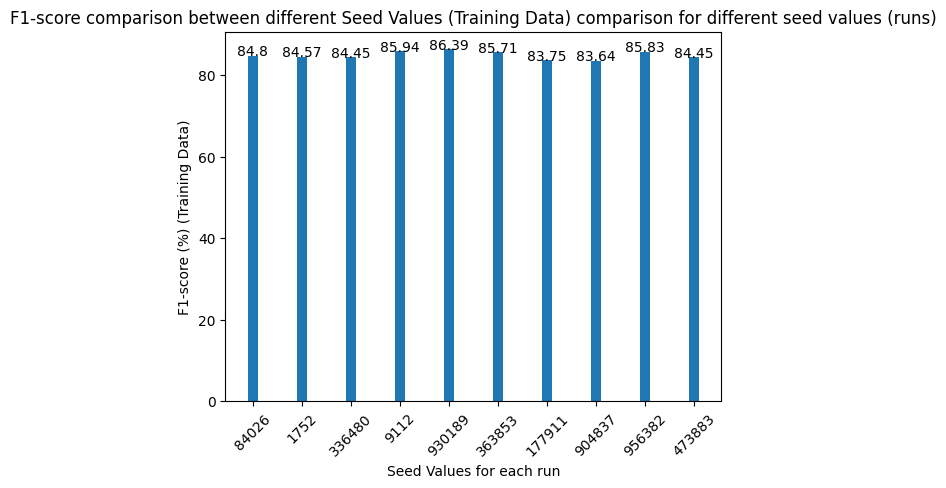

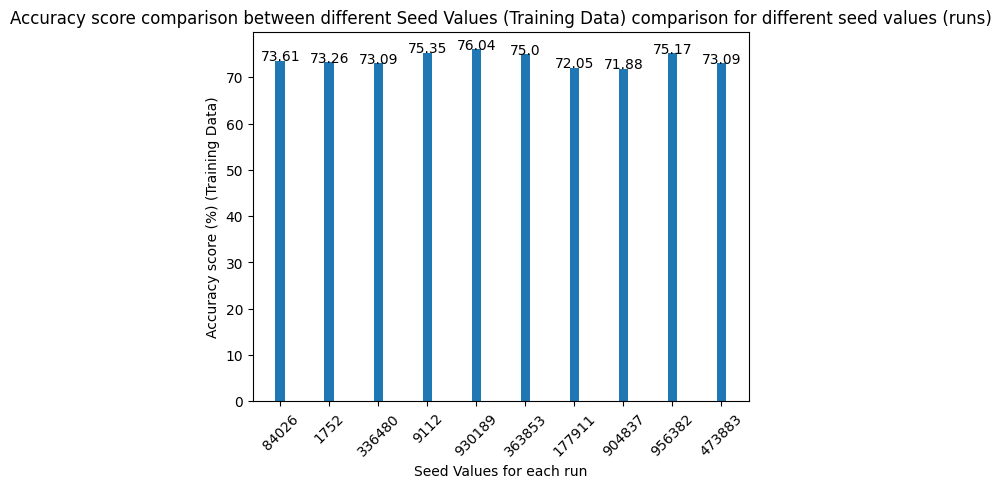

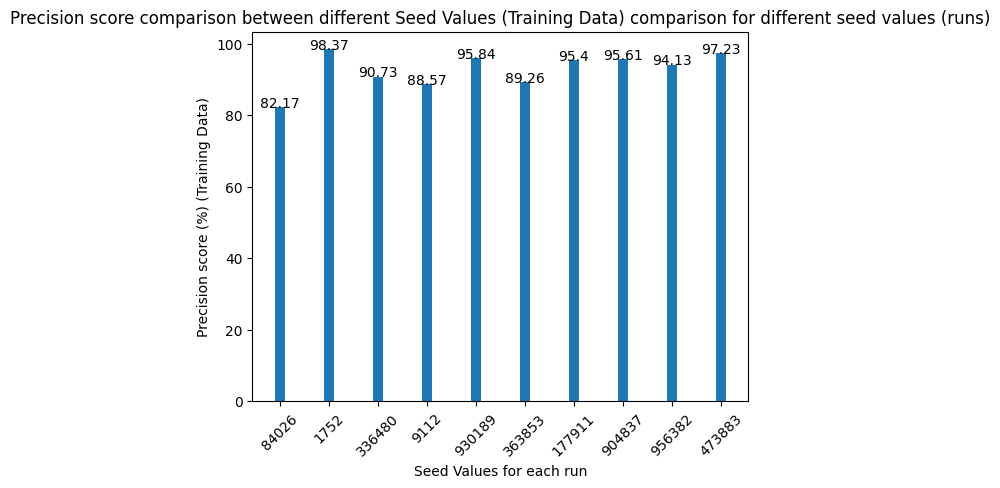

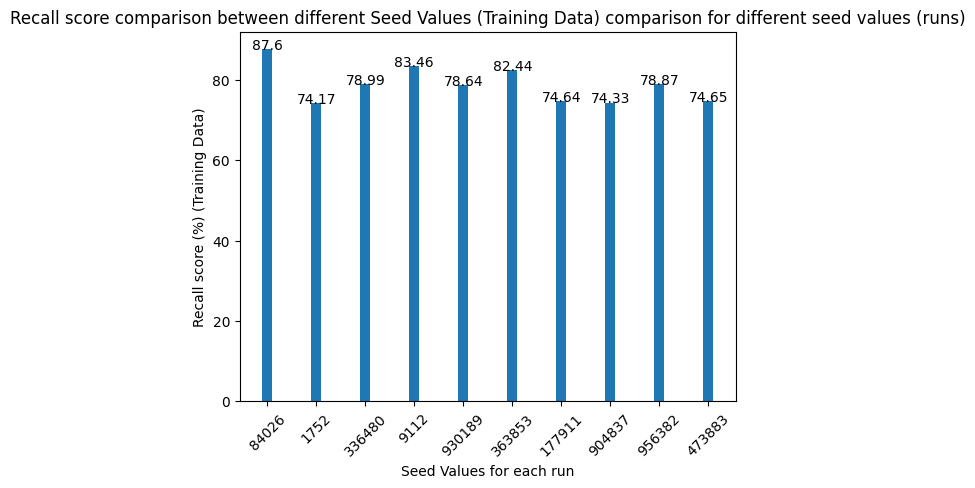

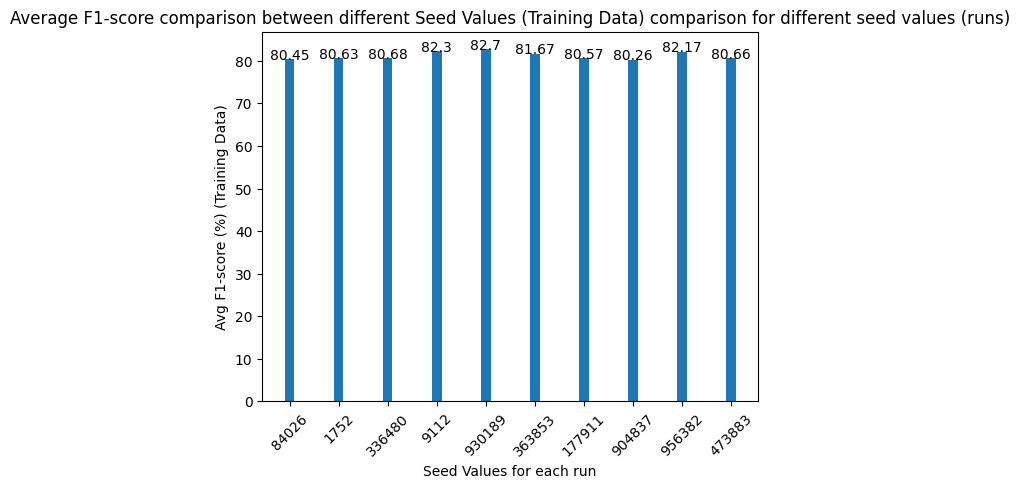

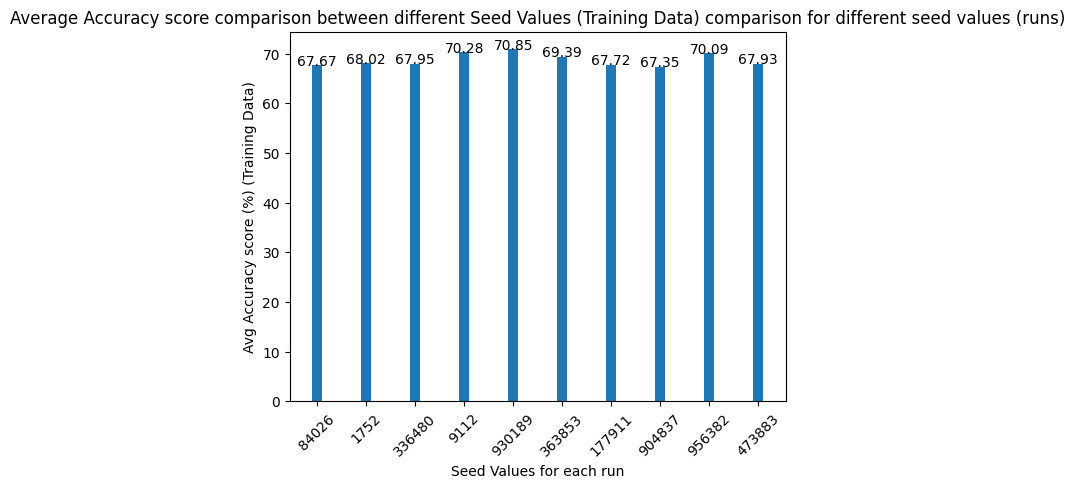

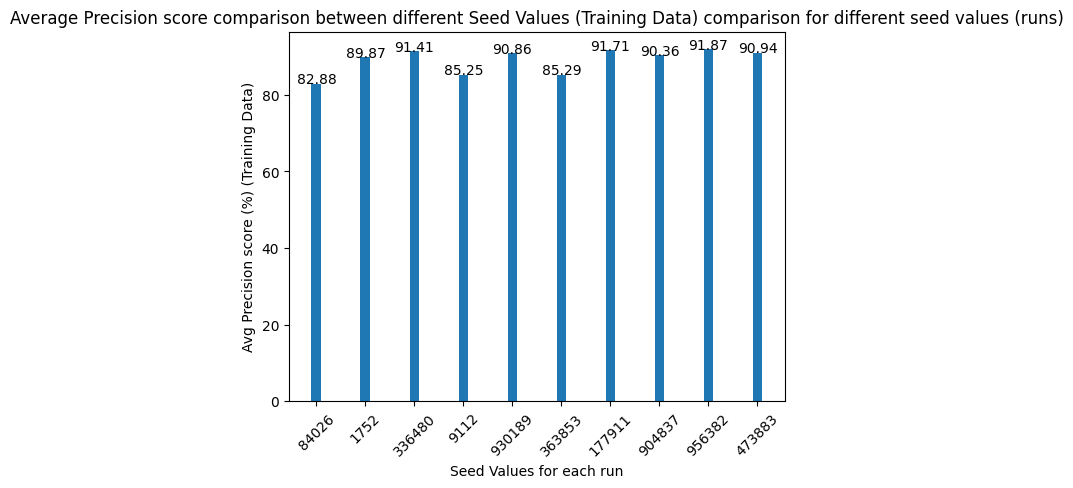

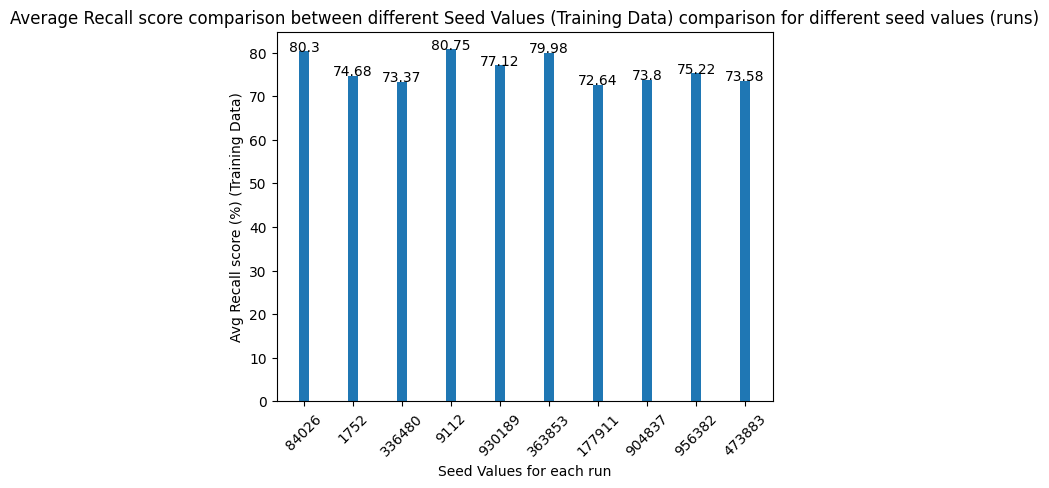

In [38]:
file = open("source_seed_results_training.txt", 'r')
lines = file.readlines()

seeds = []
best_f1_scores = []
best_accuracy_scores = []
best_precision_scores = []
best_recall_scores = []
avg_f1_scores = []
avg_accuracy_scores = []
avg_precision_scores = []
avg_recall_scores = []

# Strips the newline character
for line in lines:
    # Remove trailing newline character (if any)
    line = line.strip()
    data = line.split(',')
    seeds.append(data[0])
    best_f1_scores.append(float(data[1]))               
    best_accuracy_scores.append(float(data[2]))
    best_precision_scores.append(float(data[3]))
    best_recall_scores.append(float(data[4]))
    avg_f1_scores.append(float(data[5]))
    avg_accuracy_scores.append(float(data[6]))
    avg_precision_scores.append(float(data[7]))
    avg_recall_scores.append(float(data[8]))
# Close the file
file.close()

x_labels = [seed for seed in seeds]

plot_barplot(x_labels, best_f1_scores, "F1-score (%) (Training Data)", "F1-score comparison between different Seed Values (Training Data)")
plot_barplot(x_labels, best_accuracy_scores, "Accuracy score (%) (Training Data)", "Accuracy score comparison between different Seed Values (Training Data)")
plot_barplot(x_labels, best_precision_scores, "Precision score (%) (Training Data)", "Precision score comparison between different Seed Values (Training Data)")
plot_barplot(x_labels, best_recall_scores, "Recall score (%) (Training Data)", "Recall score comparison between different Seed Values (Training Data)")
plot_barplot(x_labels, avg_f1_scores, "Avg F1-score (%) (Training Data)", "Average F1-score comparison between different Seed Values (Training Data)")
plot_barplot(x_labels, avg_accuracy_scores, "Avg Accuracy score (%) (Training Data)", "Average Accuracy score comparison between different Seed Values (Training Data)")
plot_barplot(x_labels, avg_precision_scores, "Avg Precision score (%) (Training Data)", "Average Precision score comparison between different Seed Values (Training Data)")
plot_barplot(x_labels, avg_recall_scores, "Avg Recall score (%) (Training Data)", "Average Recall score comparison between different Seed Values (Training Data)")

In [50]:
# os.remove('target1_seed_results_training.txt')